## Stanford Cars

### Environment
* cudatoolkit     11.3.1
* cudnn           8.2.1.32
* tensorflow-gpu  2.6.0
* keras-gpu       2.6.0
* pytorch         2.3.0
* python          3.9.15

Create a new environment, aiml, from base environment:

conda create --name aiml python=3.9

Install the conda-forge packages first

conda install -c conda-forge cudatoolkit cudnn tensorflow-gpu torchvision torchaudio pytorch-cuda -c pytorch -c nvidia

Install from regular coda repository

conda install tensorflow-gpu keras-gpu


Dataset from https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder

Create a folder, Dataset, in the directory of the current notebook and put the files:
* ***anno_test.csv***
* ***anno_train.csv***
* ***names.csv***
* ***train*** folder 8144 images cars_train_annos
* ***test*** folder  8041 images cars_test_annos_withlabels

https://paperswithcode.com/sota/image-classification-on-stanford-cars

### Import Libraries

In [1]:
import numpy as np
np.object = object
np.int = int
np.float = float
np.bool = bool
np.random.seed(42)

In [2]:
import pandas as pd

In [3]:
import os
import shutil
import pickle
import time
from datetime import datetime
import logging
import pprint
import glob

In [4]:
start = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

In [7]:
import tensorflow as tf

### Set GPU memory growth

In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print(e)

In [9]:
from tensorflow.python.client import device_lib

In [10]:
import albumentations as A

In [11]:
# Importing custom functions from the `myfuncs` module
from myfuncs.correct_folder_structure import correct_folder_structure
from myfuncs.get_image_paths_and_labels import get_image_paths_and_labels
from myfuncs.save_augmented_images import save_augmented_images
from myfuncs.create_data_generators import create_data_generators
from myfuncs.perform_hyperparameter_search import perform_hyperparameter_search
from myfuncs.save_hyperparameters import save_hyperparameters
from myfuncs.run_model_pipeline import run_model_pipeline

from myfuncs.create_model1 import create_model1
from myfuncs.create_alexnet_model import create_alexnet_model
from myfuncs.create_vgg16_model import create_vgg16_model
from myfuncs.create_resnet50_model import create_resnet50_model
from myfuncs.create_densenet_model import create_densenet_model
from myfuncs.create_imagenet_model import create_imagenet_model
from myfuncs.create_efficientnet_model import create_efficientnet_model
from myfuncs.create_inceptionv3_model import create_inceptionv3_model

from myfuncs.print_model_summaries import print_model_summaries

from myfuncs.load_hyperparameters import load_hyperparameters
from myfuncs.inspect_histories import inspect_histories
from myfuncs.train_model import train_model
from myfuncs.train_and_profile import train_and_profile
from myfuncs.plot_history import plot_history
from myfuncs.extract_history_data import extract_history_data
from myfuncs.get_test_data import get_test_data
from myfuncs.evaluate_model_on_test_data import evaluate_model_on_test_data
from myfuncs.plot_test_results import plot_test_results

# from myfuncs.mixup import mixup
# from myfuncs.cutmix import cutmix
# from myfuncs.random_erasing import random_erasing
# from myfuncs.metrics import metrics
# from myfuncs.f1_score import f1_score
# from myfuncs.attention_block import AttentionBlock
# from myfuncs.se_block import SEBlock
# from myfuncs.custom_layer_alexnet import CustomLayerAlexNet
# from myfuncs.create_model_for_optuna import create_model_for_optuna
# from myfuncs.AlbumentationsImageDataGenerator import AlbumentationsImageDataGenerator
# from myfuncs.create_callbacks import create_callbacks
# from myfuncs.plot_train_results import plot_train_results
# from myfuncs.create_model import create_model

In [12]:
import watermark
%load_ext watermark

In [13]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.18.1

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 151 Stepping 2, GenuineIntel
CPU cores   : 24
Architecture: 64bit

Git hash: 

watermark     : 2.5.0
sklearn       : 1.5.2
tensorflow    : 2.6.0
logging       : 0.5.1.2
numpy         : 1.26.4
pandas        : 2.2.3
matplotlib    : 3.9.1
albumentations: 1.3.1



In [14]:
start = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

### Enable logging

In [15]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### Enable Mixed Precision Training and XLA Compilation

In [16]:
# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Enable XLA (Accelerated Linear Algebra) compilation
# tf.config.optimizer.set_jit(True)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti Laptop GPU, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti Laptop GPU, compute capability 8.6


In [17]:
# Disable eager execution
# tf.compat.v1.disable_eager_execution()

### Load CSV files

In [18]:
# Load names and annotations
names = pd.read_csv('Dataset/car_data/names.csv', header=None)
anno_train = pd.read_csv('Dataset/car_data/anno_train.csv', header='infer')
anno_test = pd.read_csv('Dataset/car_data/anno_test.csv', header='infer')
# anno_train = pd.read_csv('Dataset/car_data/anno_train_corrected.csv', header='infer')
# anno_test = pd.read_csv('Dataset/car_data/anno_test_corrected.csv', header='infer')

### Define directories for train and test data

In [19]:
train_dir = 'Dataset/car_data/train'
test_dir = 'Dataset/car_data/test'
augmented_dir = 'Dataset/car_data/augmented'
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)

In [20]:
# Create directories for each car model in the augmented directory
car_models = names[0].values
correct_folder_structure(augmented_dir, names[0].values)

In [21]:
print(len(car_models))

196


In [22]:
# Get image paths and labels
train_file_paths, train_labels = get_image_paths_and_labels(anno_train, train_dir, names)
test_file_paths, test_labels = get_image_paths_and_labels(anno_test, test_dir, names)
# train_file_paths = glob.glob(os.path.join(train_dir, '**', '*.jpg'), recursive=True)
# test_file_paths = glob.glob(os.path.join(test_dir, '**', '*.jpg'), recursive=True)

In [23]:
# Convert labels to NumPy array for reshaping
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [24]:
# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
train_labels = encoder.fit_transform(train_labels.reshape(-1, 1)).astype(np.float32)
test_labels = encoder.transform(test_labels.reshape(-1, 1)).astype(np.float32)
# train_labels = encoder.fit_transform(pd.DataFrame(train_labels)).astype(np.float32)
# test_labels = encoder.transform(pd.DataFrame(test_labels)).astype(np.float32)
# train_bboxes = anno_train[['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values
# test_boxes = anno_test[['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values

In [25]:
#print(train_file_paths)

### Global variables

In [26]:
num_classes = 196
size = (224, 224)
input_shape = (224, 224, 3)
batch_size = 128       # 128
epochs = 22
seed = 42
learning_rate = 1e-6  # 1e-4
weight_decay =  1e-6  # 1e-4
dropout = 0.5

augmentations = None

### Data augmentation using albumentations

In [27]:
# https://albumentations.ai/docs/getting_started/image_augmentation/

In [28]:
# Define augmentations
augmentations = A.Compose([
#     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0),
    A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=12, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=4, p=0.2),
    # A.RandomCrop(height=size[0], width=size[1], p=0.8),
    A.GaussianBlur(blur_limit=(3, 5), p=0.6),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.2)
])


In [29]:
st1 = time.time()
st2 = time.process_time()

In [30]:
if train_file_paths:
    save_augmented_images(
    file_paths=train_file_paths,
    augmentations=augmentations,
    image_size=(224, 224),
    num_augmentations=6,
    augmented_dir=augmented_dir
)

100%|██████████████████████████████████████████████████████████████████████████████| 8144/8144 [08:26<00:00, 16.07it/s]

Augmented images saved successfully.
Incorrect folder 'Dataset/car_data/augmented\Ram C' has been deleted.


In [31]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 1838.677 seconds
Execution time: 30.645 minutes
CPU Execution time: 271.203 seconds
CPU Execution time: 4.520 minutes


### Update directories for train and test data

In [32]:
train_dir = 'Dataset/car_data/augmented'
# print("train_file_paths: ", train_file_paths)
# print("test_file_paths: ", test_file_paths)

In [33]:
folder_to_remove = 'Ram C'
folder_path = os.path.join(train_dir, folder_to_remove)

# Check if the folder exists before attempting to remove it
if os.path.exists(folder_path) and os.path.isdir(folder_path):
    try:
        shutil.rmtree(folder_path)  # This will remove the folder and its contents
        print(f'Folder "{folder_to_remove}" has been removed successfully.')
    except Exception as e:
        print(f'Error removing folder: {e}')
else:
    print(f'Folder "{folder_to_remove}" does not exist in the directory.')

Folder "Ram C" does not exist in the directory.


In [34]:
# Create the data generators
train_generator, test_generator = create_data_generators(
    input_shape=size,
    batch_size=batch_size,
    train_dir=train_dir,
    test_dir=test_dir,
)

Found 48864 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [35]:
# print(train_generator.class_indices)
# print(test_generator.class_indices)
# print(len(train_generator.class_indices))
# print(len(test_generator.class_indices))

In [36]:
num_classes = len(train_generator.class_indices)  # Automatically inferred from the generator

### Training and evaluation with K-fold cross-validation

In [37]:
# uncomment below to enable k-fold (not used because it increases the computations drastically)
# kf = KFold(n_splits=2, shuffle=True, random_state=seed)
# kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# fold_no = 1
# all_histories = []


# # Iterate over each fold
# for train_index, val_index in kf.split(train_file_paths):
#     print(f'Training fold {fold_no}...')
    
#     # Split the data into training and validation sets
#     train_paths, val_paths = np.array(train_file_paths)[train_index], np.array(train_file_paths)[val_index]
#     train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

#     # Create the data generators for the current fold
#     train_generator = create_data_generators(
#         input_shape=size,
#         batch_size=32,
#         train_paths=train_paths,
#         train_labels=train_labels_fold
#     )

#     val_generator = create_data_generators(
#         input_shape=size,
#         batch_size=32,
#         train_paths=val_paths,
#         train_labels=val_labels_fold
#     )

### Hyperparameter Search

In [38]:
default_hyperparams = {
    'learning_rate': 1e-6,        # 1e-6
    'weight_decay': 1e-6,         # Regularization strength, 1e-6
    'dropout': 0.5,               # Dropout rate to prevent overfitting
#     'optimizer_type': 'Adam',   # Optimizer type, usually 'Adam', 'SGD', or 'RMSprop'
    'beta_1': 0.9,                # Beta_1 value for the Adam optimizer
    'beta_2': 0.999,              # Beta_2 value for the Adam optimizer
    'decay': 1e-6,                # Learning rate decay, 1e-6
    'momentum': 0.9,              # Momentum for SGD (not relevant for Adam)
    'rho': 0.9,                   # Used in RMSprop optimizer
    'optimizer_type': 'Adam'      # Add the optimizer type (Adam, SGD, or RMSprop)
}

In [39]:
# Hyperparameter Search
best_params = perform_hyperparameter_search(train_generator)

# Save the best hyperparameters
save_hyperparameters('model', best_params)


Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.464321002364159e-05.
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping

Epoch 00003: ReduceLROnPlateau reducing learning rate to 8.152517839334906e-05.
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping

Epoch 00005: ReduceLROnPlateau reducing learning rate to 6.511754327220843e-06.

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
Best parameters: {'optimizer_type': 'Adam', 'learning_rate': 0.001, 'weight_decay': 1e-06, 'dropout': 0.7, 'beta_1': 0.85, 'beta_2': 0.999, 'decay': 1e-06, 'momentum': 1.0, 'rho': 0.8660907205957895}
Best score: -5.295836925506592


In [40]:
print(best_params)

{'optimizer_type': 'Adam', 'learning_rate': 0.001, 'weight_decay': 1e-06, 'dropout': 0.7, 'beta_1': 0.85, 'beta_2': 0.999, 'decay': 1e-06, 'momentum': 1.0, 'rho': 0.8660907205957895}


In [41]:
# List of models to run
model_functions = {
    'model1': create_model1,
    'AlexNet': create_alexnet_model,
    'VGG16': create_vgg16_model,
    'ResNet50': create_resnet50_model,
    'DenseNet': create_densenet_model,
    'ImageNet': create_imagenet_model,
    'EfficientNet': create_efficientnet_model,
    'InceptionV3': create_inceptionv3_model
}

In [42]:
model1_def = create_model1(input_shape, num_classes, default_hyperparams)

In [43]:
alexnet_def = create_alexnet_model(input_shape, num_classes, default_hyperparams)

In [44]:
vgg16_def = create_vgg16_model(input_shape, num_classes, default_hyperparams)

Number of all layers in a feature-extractor part of model: 19.
Number of freezed (untrainable) layers in a feature-extractor part of model: 0.


In [45]:
resnet50_def = create_resnet50_model(input_shape, num_classes, default_hyperparams)

Number of all layers in the feature-extractor part of the model: 175.
Number of frozen (untrainable) layers in the feature-extractor part of the model: 0.


In [46]:
densenet_def = create_densenet_model(input_shape, num_classes, default_hyperparams)

In [47]:
imagenet_def = create_imagenet_model(input_shape, num_classes, default_hyperparams)

In [48]:
efficientnet_def = create_efficientnet_model(input_shape, num_classes, default_hyperparams)

In [49]:
inceptionv3_def = create_inceptionv3_model(input_shape, num_classes, default_hyperparams)

Number of all layers in the feature-extractor part of the model: 311.
Number of frozen (untrainable) layers in the feature-extractor part of the model: 0.


In [50]:
models_def = [model1_def, alexnet_def, vgg16_def, resnet50_def, densenet_def, imagenet_def, efficientnet_def, inceptionv3_def]
model_names = ['Model1', 'AlexNet', 'VGG16', 'ResNet50', 'DenseNet','ImageNet','EfficientNet', 'InceptionV3']
print_model_summaries(models_def, model_names)

Summary for Model1:
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None

Summary for InceptionV3:
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 111, 111, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 111, 111, 32) 96          conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization_5[0][0]      
___________________________________________________________________

## Training using default hyperparameters

In [51]:
histories_def_hp = {}

### Train Model1

In [52]:
st1 = time.time()
st2 = time.process_time()

Training model: model1
Summary for model1:
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_119 

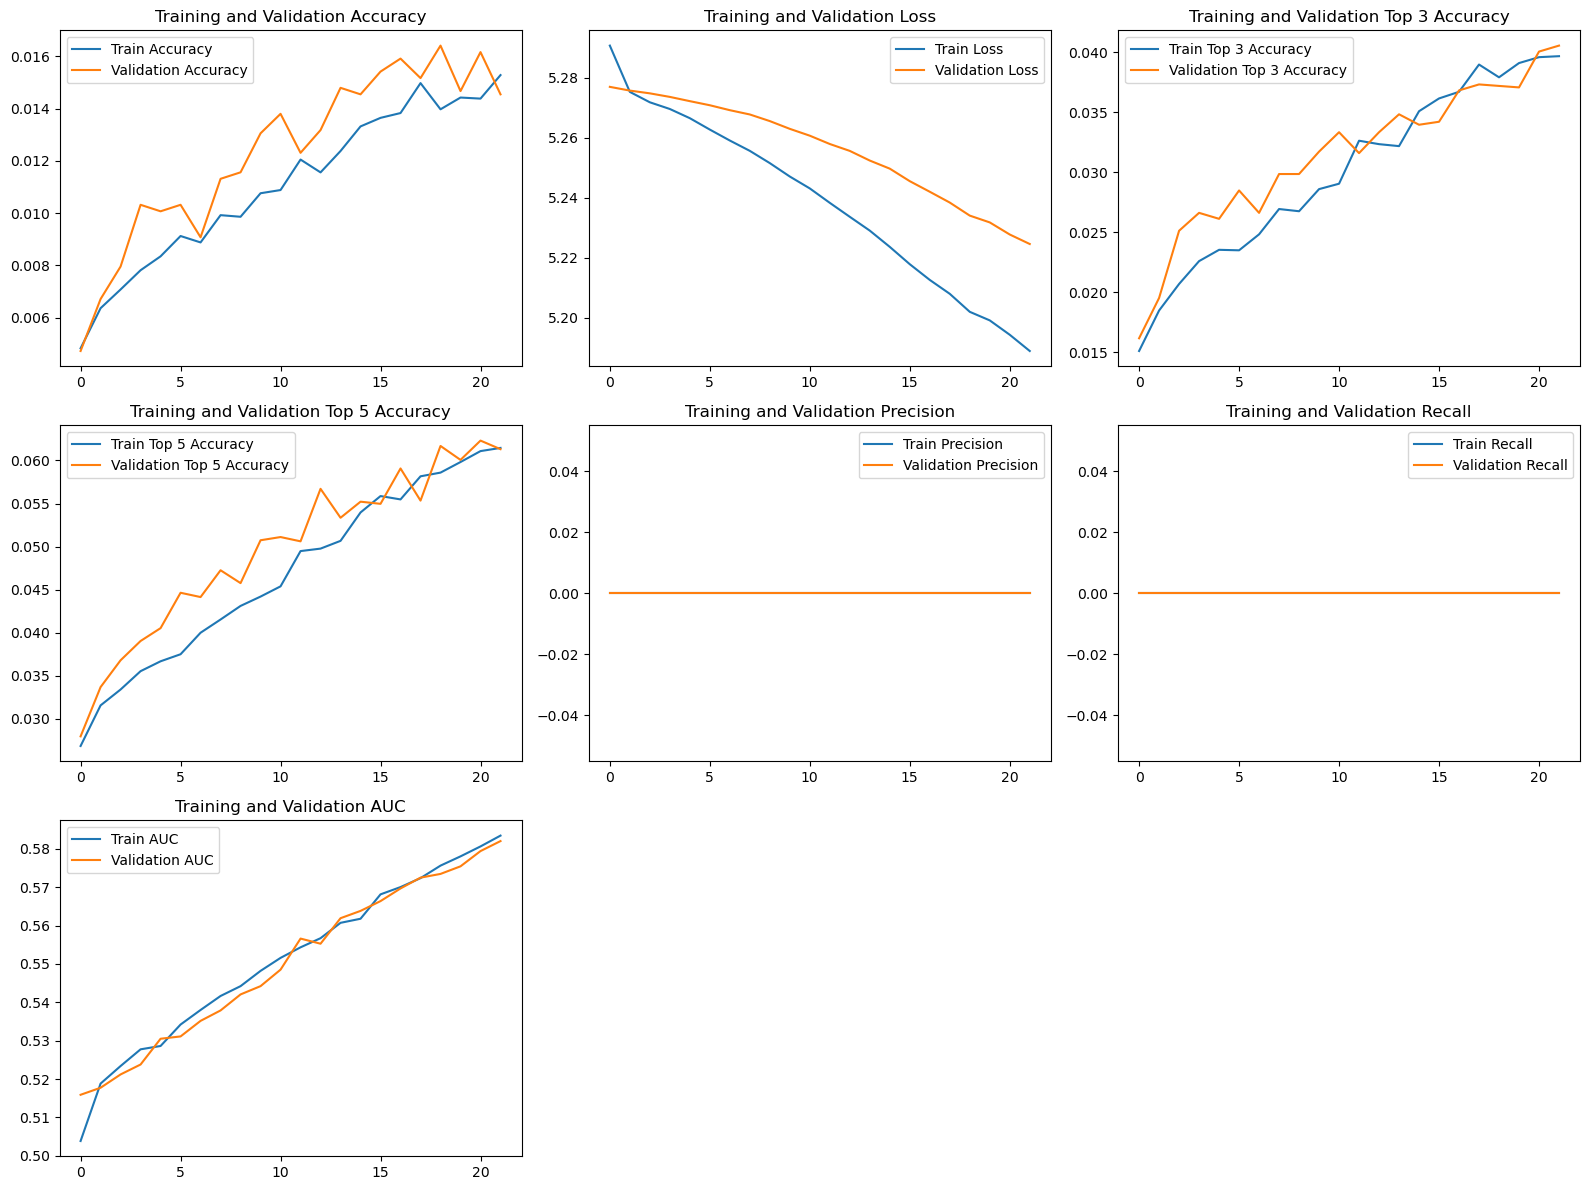

In [53]:
# Model bil-sayf par Salim
# Train model1
print("Training model: model1")
histories_def_hp['model1'] = run_model_pipeline(create_model1, 'model1', default_hyperparams, input_shape, num_classes, train_generator, test_generator, epochs)


In [54]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 11278.783 seconds
Execution time: 187.980 minutes
CPU Execution time: 5415.547 seconds
CPU Execution time: 90.259 minutes


### Train Model 2 - AlexNet

In [55]:
st1 = time.time()
st2 = time.process_time()

Training model: AlexNet
Summary for AlexNet:
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 54, 54, 96)        34944     
_________________________________________________________________
spatial_dropout2d_8 (Spatial (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
batch_normalization_99 (Batc (None, 26, 26, 96)        384       
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 26, 26, 256)       614656    
_________________________________________________________________
spatial_dropou

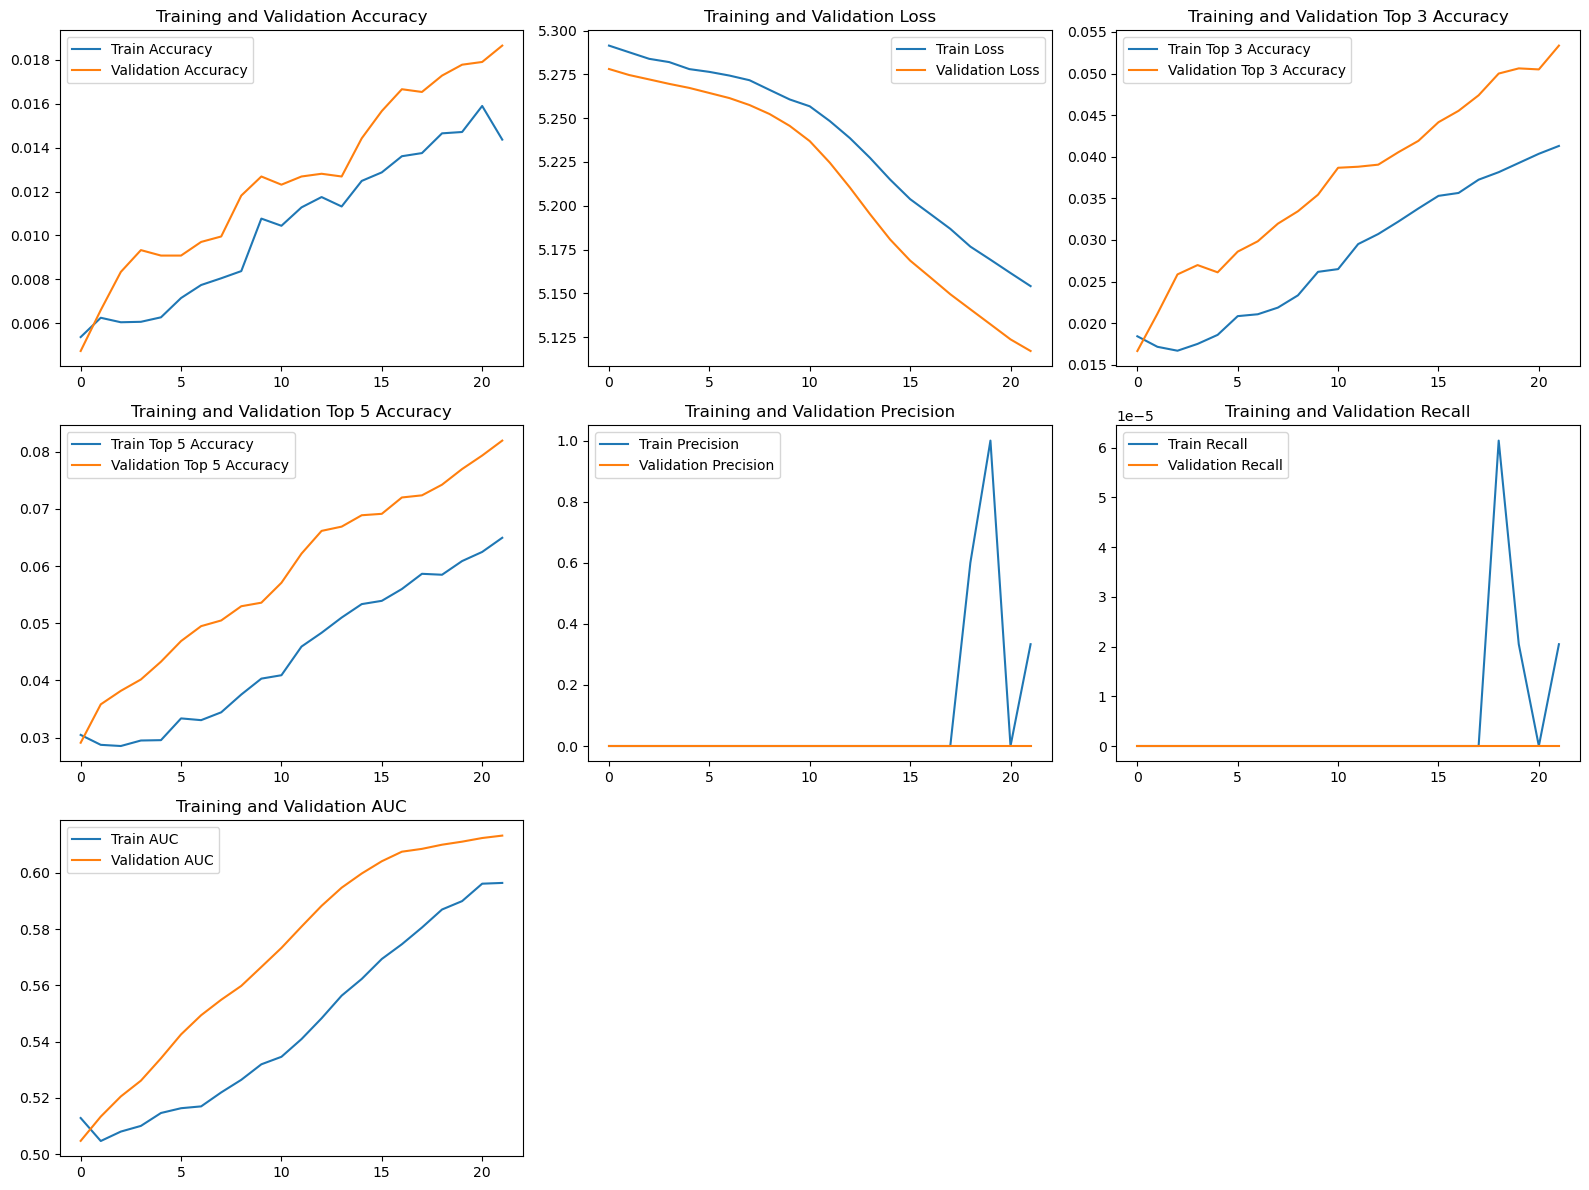

In [56]:
# Train AlexNet
print("Training model: AlexNet")
histories_def_hp['AlexNet'] = run_model_pipeline(create_alexnet_model, 'AlexNet', default_hyperparams, input_shape, num_classes, train_generator, test_generator, epochs)


In [57]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 11089.696 seconds
Execution time: 184.828 minutes
CPU Execution time: 6071.812 seconds
CPU Execution time: 101.197 minutes


### Train Model 3 - VGG16

In [58]:
st1 = time.time()
st2 = time.process_time()

Training model: VGG16
Number of all layers in a feature-extractor part of model: 19.
Number of freezed (untrainable) layers in a feature-extractor part of model: 0.
Summary for VGG16:
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_


Epoch 00008: val_top_3_acc improved from 0.08693 to 0.09961, saving model to VGG16_fold_1.h5
Epoch 9/22
382/382 [==============================] - 501s 1s/step - loss: 5.0552 - categorical_accuracy: 0.0286 - accuracy: 0.0286 - top_3_acc: 0.0677 - top_5_acc: 0.0994 - precision: 0.4286 - recall: 6.1395e-05 - auc: 0.6441 - val_loss: 4.9261 - val_categorical_accuracy: 0.0497 - val_accuracy: 0.0497 - val_top_3_acc: 0.1117 - val_top_5_acc: 0.1591 - val_precision: 1.0000 - val_recall: 1.2436e-04 - val_auc: 0.7064

Epoch 00009: val_top_3_acc improved from 0.09961 to 0.11168, saving model to VGG16_fold_1.h5
Epoch 10/22
382/382 [==============================] - 500s 1s/step - loss: 5.0104 - categorical_accuracy: 0.0310 - accuracy: 0.0310 - top_3_acc: 0.0744 - top_5_acc: 0.1099 - precision: 0.3636 - recall: 8.1860e-05 - auc: 0.6599 - val_loss: 4.8661 - val_categorical_accuracy: 0.0591 - val_accuracy: 0.0591 - val_top_3_acc: 0.1295 - val_top_5_acc: 0.1760 - val_precision: 1.0000 - val_recall: 2.

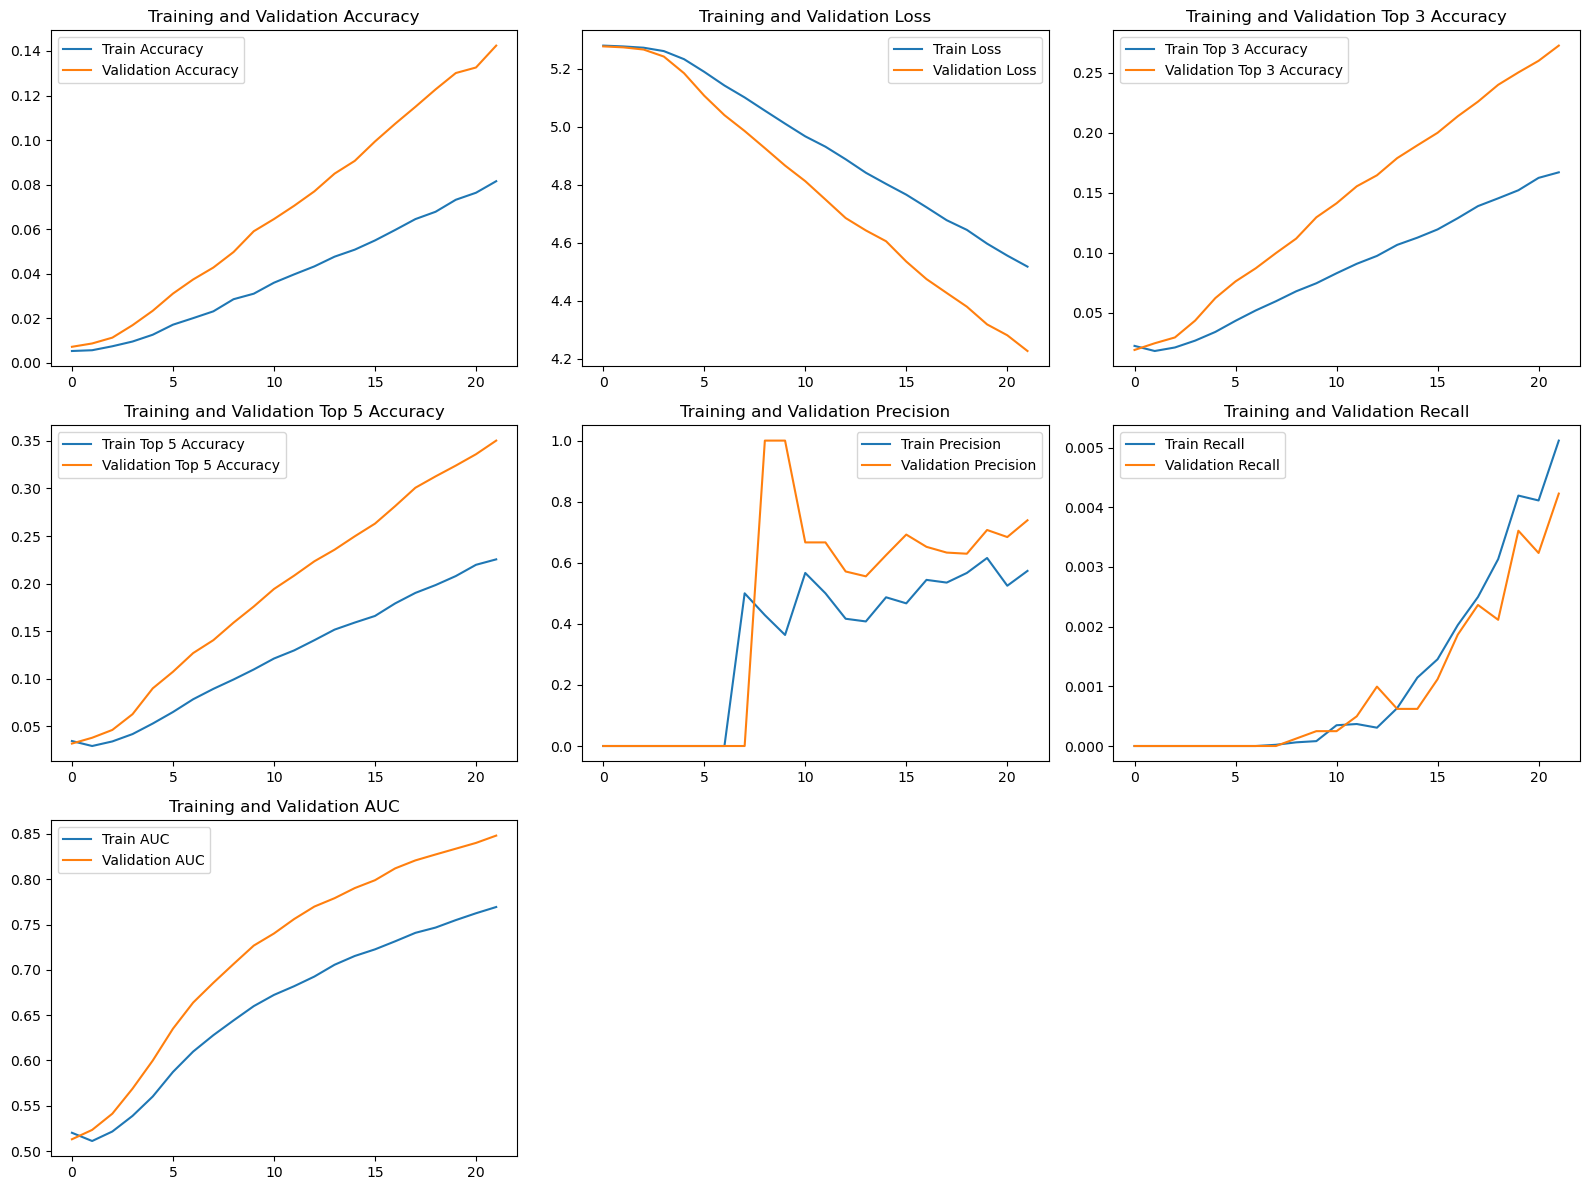

In [59]:
# Train VGG16
print("Training model: VGG16")
histories_def_hp['VGG16'] = run_model_pipeline(create_vgg16_model, 'VGG16', default_hyperparams, input_shape, num_classes, train_generator, test_generator, epochs)


In [60]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 11590.896 seconds
Execution time: 193.182 minutes
CPU Execution time: 8195.594 seconds
CPU Execution time: 136.593 minutes


### Train Model 4 - ResNet50

In [61]:
st1 = time.time()
st2 = time.process_time()

Training model: ResNet50
Number of all layers in the feature-extractor part of the model: 175.
Number of frozen (untrainable) layers in the feature-extractor part of the model: 0.
Summary for ResNet50:
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
________________________________________________________________________________________

Epoch 1/22
382/382 [==============================] - 564s 1s/step - loss: 5.2792 - categorical_accuracy: 0.0057 - accuracy: 0.0057 - top_3_acc: 0.0524 - top_5_acc: 0.0730 - precision: 0.7391 - recall: 5.9749e-04 - auc: 0.5619 - val_loss: 5.2797 - val_categorical_accuracy: 0.0029 - val_accuracy: 0.0029 - val_top_3_acc: 0.0113 - val_top_5_acc: 0.0205 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5016

Epoch 00001: val_top_3_acc improved from -inf to 0.01132, saving model to ResNet50_fold_1.h5


C:\anaconda3\envs\dlproj\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/22
382/382 [==============================] - 510s 1s/step - loss: 5.2765 - categorical_accuracy: 0.0056 - accuracy: 0.0056 - top_3_acc: 0.0177 - top_5_acc: 0.0285 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5114 - val_loss: 5.2770 - val_categorical_accuracy: 0.0068 - val_accuracy: 0.0068 - val_top_3_acc: 0.0198 - val_top_5_acc: 0.0330 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5087

Epoch 00002: val_top_3_acc improved from 0.01132 to 0.01977, saving model to ResNet50_fold_1.h5
Epoch 3/22
382/382 [==============================] - 512s 1s/step - loss: 5.2733 - categorical_accuracy: 0.0070 - accuracy: 0.0070 - top_3_acc: 0.0198 - top_5_acc: 0.0331 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5202 - val_loss: 5.2722 - val_categorical_accuracy: 0.0102 - val_accuracy: 0.0102 - val_top_3_acc: 0.0284 - val_top_5_acc: 0.0409 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5215

Epoch 00003: val_top_3_acc improved from 0.01977


Epoch 00017: val_top_3_acc improved from 0.09899 to 0.10136, saving model to ResNet50_fold_1.h5
Epoch 18/22
382/382 [==============================] - 505s 1s/step - loss: 5.0148 - categorical_accuracy: 0.0469 - accuracy: 0.0469 - top_3_acc: 0.0951 - top_5_acc: 0.1309 - precision: 0.7301 - recall: 0.0105 - auc: 0.6481 - val_loss: 4.9720 - val_categorical_accuracy: 0.0550 - val_accuracy: 0.0550 - val_top_3_acc: 0.1077 - val_top_5_acc: 0.1501 - val_precision: 0.8056 - val_recall: 0.0144 - val_auc: 0.6796

Epoch 00018: val_top_3_acc improved from 0.10136 to 0.10770, saving model to ResNet50_fold_1.h5
Epoch 19/22
382/382 [==============================] - 511s 1s/step - loss: 4.9892 - categorical_accuracy: 0.0501 - accuracy: 0.0501 - top_3_acc: 0.1011 - top_5_acc: 0.1356 - precision: 0.7654 - recall: 0.0124 - auc: 0.6574 - val_loss: 4.9384 - val_categorical_accuracy: 0.0577 - val_accuracy: 0.0577 - val_top_3_acc: 0.1159 - val_top_5_acc: 0.1584 - val_precision: 0.8531 - val_recall: 0.0152 

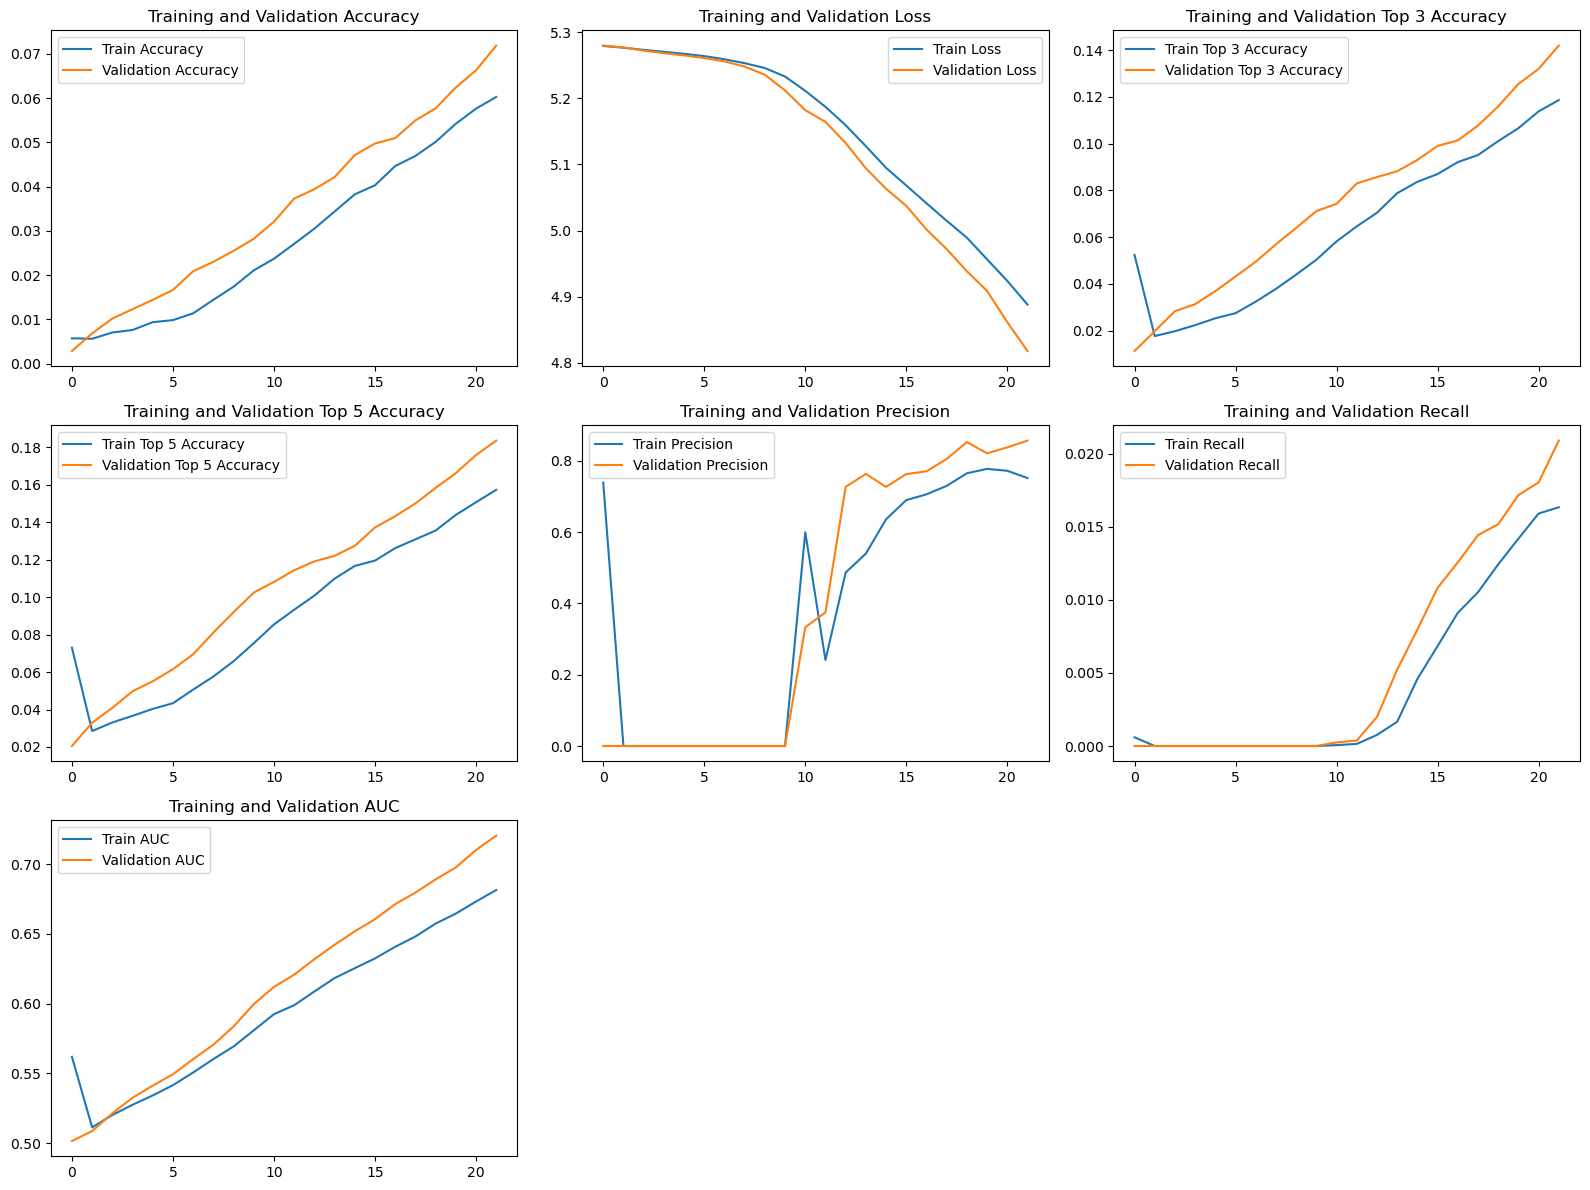

In [62]:
# Train ResNet50
print("Training model: ResNet50")
histories_def_hp['ResNet50'] = run_model_pipeline(create_resnet50_model, 'ResNet50', default_hyperparams, input_shape, num_classes, train_generator, test_generator, epochs)


In [63]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 11236.269 seconds
Execution time: 187.271 minutes
CPU Execution time: 5677.719 seconds
CPU Execution time: 94.629 minutes


### Train Model 5 - DenseNet

In [64]:
st1 = time.time()
st2 = time.process_time()

Training model: DenseNet
Summary for DenseNet:
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________

Epoch 1/22
382/382 [==============================] - 565s 1s/step - loss: 5.3715 - categorical_accuracy: 0.0057 - accuracy: 0.0057 - top_3_acc: 0.0348 - top_5_acc: 0.0499 - precision: 0.8571 - recall: 0.0030 - auc: 0.5391 - val_loss: 5.2742 - val_categorical_accuracy: 0.0071 - val_accuracy: 0.0071 - val_top_3_acc: 0.0214 - val_top_5_acc: 0.0352 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5245

Epoch 00001: val_top_3_acc improved from -inf to 0.02139, saving model to DenseNet_fold_1.h5
Epoch 2/22
382/382 [==============================] - 552s 1s/step - loss: 5.3032 - categorical_accuracy: 0.0072 - accuracy: 0.0072 - top_3_acc: 0.0208 - top_5_acc: 0.0335 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5230 - val_loss: 5.2552 - val_categorical_accuracy: 0.0097 - val_accuracy: 0.0097 - val_top_3_acc: 0.0256 - val_top_5_acc: 0.0414 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5411

Epoch 00002: val_top_3_acc improved from 0.02139 to 0.02562


Epoch 00016: val_top_3_acc improved from 0.25084 to 0.27509, saving model to DenseNet_fold_1.h5
Epoch 17/22
382/382 [==============================] - 524s 1s/step - loss: 4.5161 - categorical_accuracy: 0.0906 - accuracy: 0.0906 - top_3_acc: 0.1831 - top_5_acc: 0.2465 - precision: 0.6644 - recall: 0.0020 - auc: 0.7807 - val_loss: 4.3225 - val_categorical_accuracy: 0.1609 - val_accuracy: 0.1609 - val_top_3_acc: 0.2991 - val_top_5_acc: 0.3830 - val_precision: 1.0000 - val_recall: 9.9490e-04 - val_auc: 0.8579

Epoch 00017: val_top_3_acc improved from 0.27509 to 0.29909, saving model to DenseNet_fold_1.h5
Epoch 18/22
382/382 [==============================] - 525s 1s/step - loss: 4.4430 - categorical_accuracy: 0.1007 - accuracy: 0.1007 - top_3_acc: 0.1999 - top_5_acc: 0.2630 - precision: 0.6964 - recall: 0.0032 - auc: 0.7916 - val_loss: 4.2306 - val_categorical_accuracy: 0.1782 - val_accuracy: 0.1782 - val_top_3_acc: 0.3255 - val_top_5_acc: 0.4095 - val_precision: 1.0000 - val_recall: 0.0

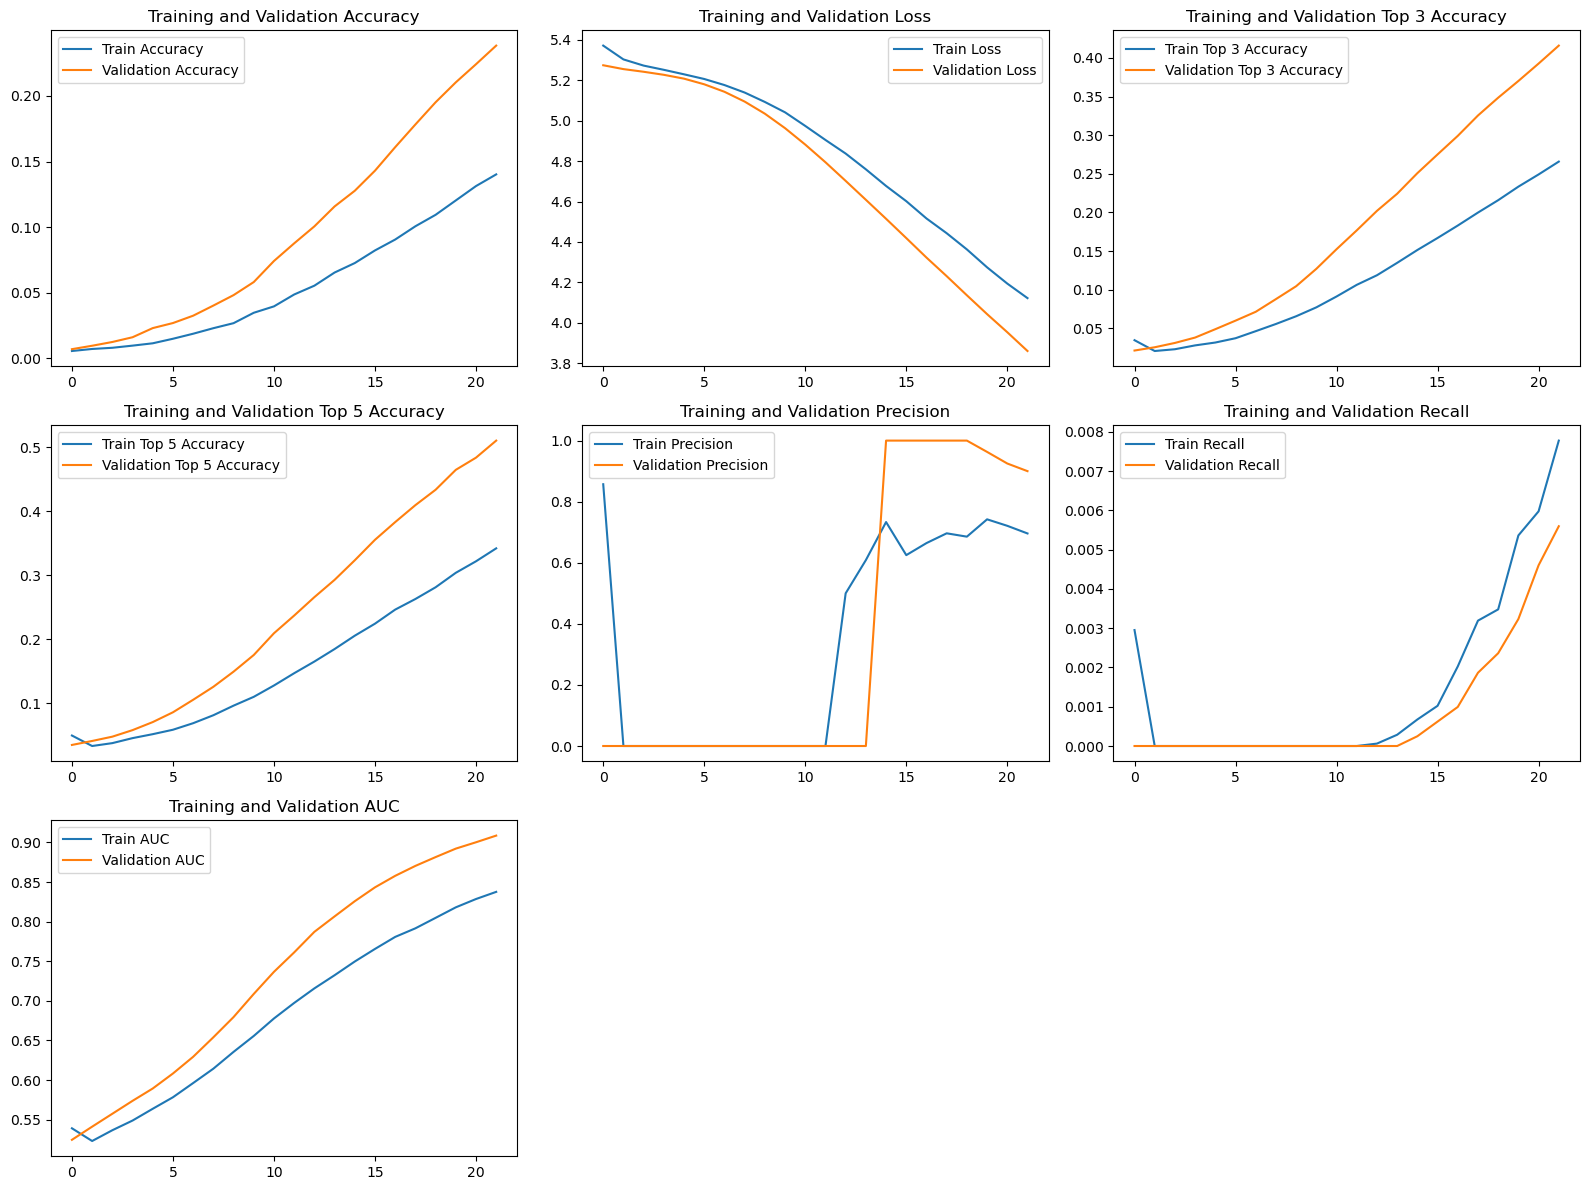

In [65]:
# Train DenseNet
print("Training model: DenseNet")
histories_def_hp['DenseNet'] = run_model_pipeline(create_densenet_model, 'DenseNet', default_hyperparams, input_shape, num_classes, train_generator, test_generator, epochs)


In [66]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 11736.415 seconds
Execution time: 195.607 minutes
CPU Execution time: 6285.328 seconds
CPU Execution time: 104.755 minutes


### Train Model 6 - ImageNet

In [67]:
st1 = time.time()
st2 = time.process_time()

Training model: ImageNet
Summary for ImageNet:
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________

Epoch 1/22
382/382 [==============================] - 535s 1s/step - loss: 5.2810 - categorical_accuracy: 0.0059 - accuracy: 0.0059 - top_3_acc: 0.0743 - top_5_acc: 0.0978 - precision: 0.9000 - recall: 7.9079e-04 - auc: 0.5786 - val_loss: 5.2793 - val_categorical_accuracy: 0.0050 - val_accuracy: 0.0050 - val_top_3_acc: 0.0146 - val_top_5_acc: 0.0267 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5065

Epoch 00001: val_top_3_acc improved from -inf to 0.01455, saving model to ImageNet_fold_1.h5
Epoch 2/22
382/382 [==============================] - 508s 1s/step - loss: 5.2566 - categorical_accuracy: 0.0096 - accuracy: 0.0096 - top_3_acc: 0.0273 - top_5_acc: 0.0430 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5413 - val_loss: 5.2509 - val_categorical_accuracy: 0.0092 - val_accuracy: 0.0092 - val_top_3_acc: 0.0302 - val_top_5_acc: 0.0497 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5536

Epoch 00002: val_top_3_acc improved from 0.01455 to 0.0

Epoch 17/22
382/382 [==============================] - 520s 1s/step - loss: 3.7647 - categorical_accuracy: 0.1921 - accuracy: 0.1921 - top_3_acc: 0.3487 - top_5_acc: 0.4346 - precision: 0.7048 - recall: 0.0304 - auc: 0.8810 - val_loss: 3.4735 - val_categorical_accuracy: 0.2767 - val_accuracy: 0.2767 - val_top_3_acc: 0.4635 - val_top_5_acc: 0.5563 - val_precision: 0.7558 - val_recall: 0.0362 - val_auc: 0.9224

Epoch 00017: val_top_3_acc improved from 0.43204 to 0.46350, saving model to ImageNet_fold_1.h5
Epoch 18/22
382/382 [==============================] - 524s 1s/step - loss: 3.6136 - categorical_accuracy: 0.2141 - accuracy: 0.2141 - top_3_acc: 0.3782 - top_5_acc: 0.4657 - precision: 0.7005 - recall: 0.0393 - auc: 0.8928 - val_loss: 3.3136 - val_categorical_accuracy: 0.3003 - val_accuracy: 0.3003 - val_top_3_acc: 0.4936 - val_top_5_acc: 0.5797 - val_precision: 0.7859 - val_recall: 0.0497 - val_auc: 0.9310

Epoch 00018: val_top_3_acc improved from 0.46350 to 0.49360, saving model to I

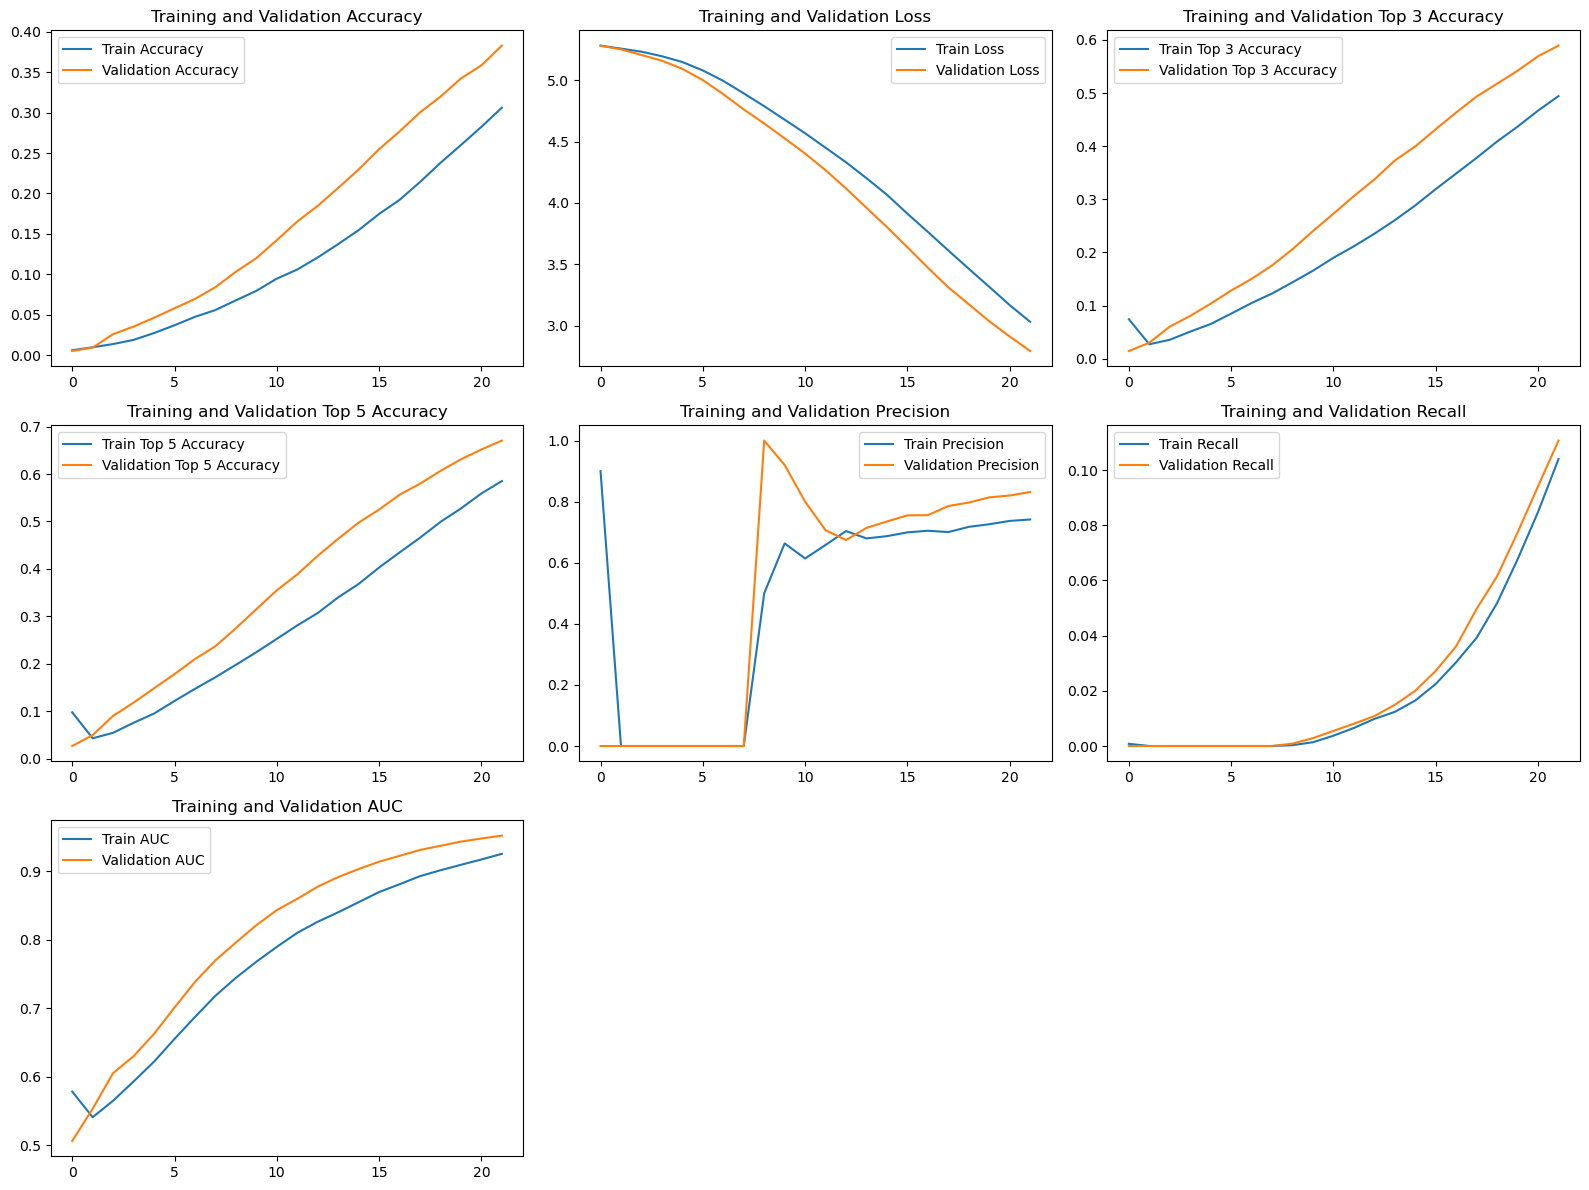

In [68]:
# Train ImageNet
print("Training model: ImageNet")
histories_def_hp['ImageNet'] = run_model_pipeline(create_imagenet_model, 'ImageNet', default_hyperparams, input_shape, num_classes, train_generator, test_generator, epochs)


In [69]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 11571.816 seconds
Execution time: 192.864 minutes
CPU Execution time: 6264.219 seconds
CPU Execution time: 104.404 minutes


### Train Model 7 - EfficientNet

In [70]:
st1 = time.time()
st2 = time.process_time()

Training model: EfficientNet
Summary for EfficientNet:
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
____________________________________

Epoch 1/22
382/382 [==============================] - 575s 1s/step - loss: 5.2805 - categorical_accuracy: 0.0051 - accuracy: 0.0051 - top_3_acc: 0.0970 - top_5_acc: 0.1182 - precision: 0.8318 - recall: 0.0156 - auc: 0.5861 - val_loss: 5.2788 - val_categorical_accuracy: 0.0053 - val_accuracy: 0.0053 - val_top_3_acc: 0.0146 - val_top_5_acc: 0.0264 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5006

Epoch 00001: val_top_3_acc improved from -inf to 0.01455, saving model to EfficientNet_fold_1.h5
Epoch 2/22
382/382 [==============================] - 520s 1s/step - loss: 5.2762 - categorical_accuracy: 0.0061 - accuracy: 0.0061 - top_3_acc: 0.0175 - top_5_acc: 0.0297 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5141 - val_loss: 5.2730 - val_categorical_accuracy: 0.0085 - val_accuracy: 0.0085 - val_top_3_acc: 0.0220 - val_top_5_acc: 0.0354 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5224

Epoch 00002: val_top_3_acc improved from 0.01455 to 0.0


Epoch 00016: val_top_3_acc improved from 0.10272 to 0.11454, saving model to EfficientNet_fold_1.h5
Epoch 17/22
382/382 [==============================] - 555s 1s/step - loss: 5.0961 - categorical_accuracy: 0.0395 - accuracy: 0.0395 - top_3_acc: 0.0918 - top_5_acc: 0.1306 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6533 - val_loss: 5.1144 - val_categorical_accuracy: 0.0484 - val_accuracy: 0.0484 - val_top_3_acc: 0.1239 - val_top_5_acc: 0.1681 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6677

Epoch 00017: val_top_3_acc improved from 0.11454 to 0.12387, saving model to EfficientNet_fold_1.h5
Epoch 18/22
382/382 [==============================] - 563s 1s/step - loss: 5.0729 - categorical_accuracy: 0.0429 - accuracy: 0.0429 - top_3_acc: 0.0968 - top_5_acc: 0.1362 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6636 - val_loss: 5.0900 - val_categorical_accuracy: 0.0578 - val_accuracy: 0.0578 - val_top_3_acc: 0.1307 - val_top_5_acc: 0.1803 - val_precisi

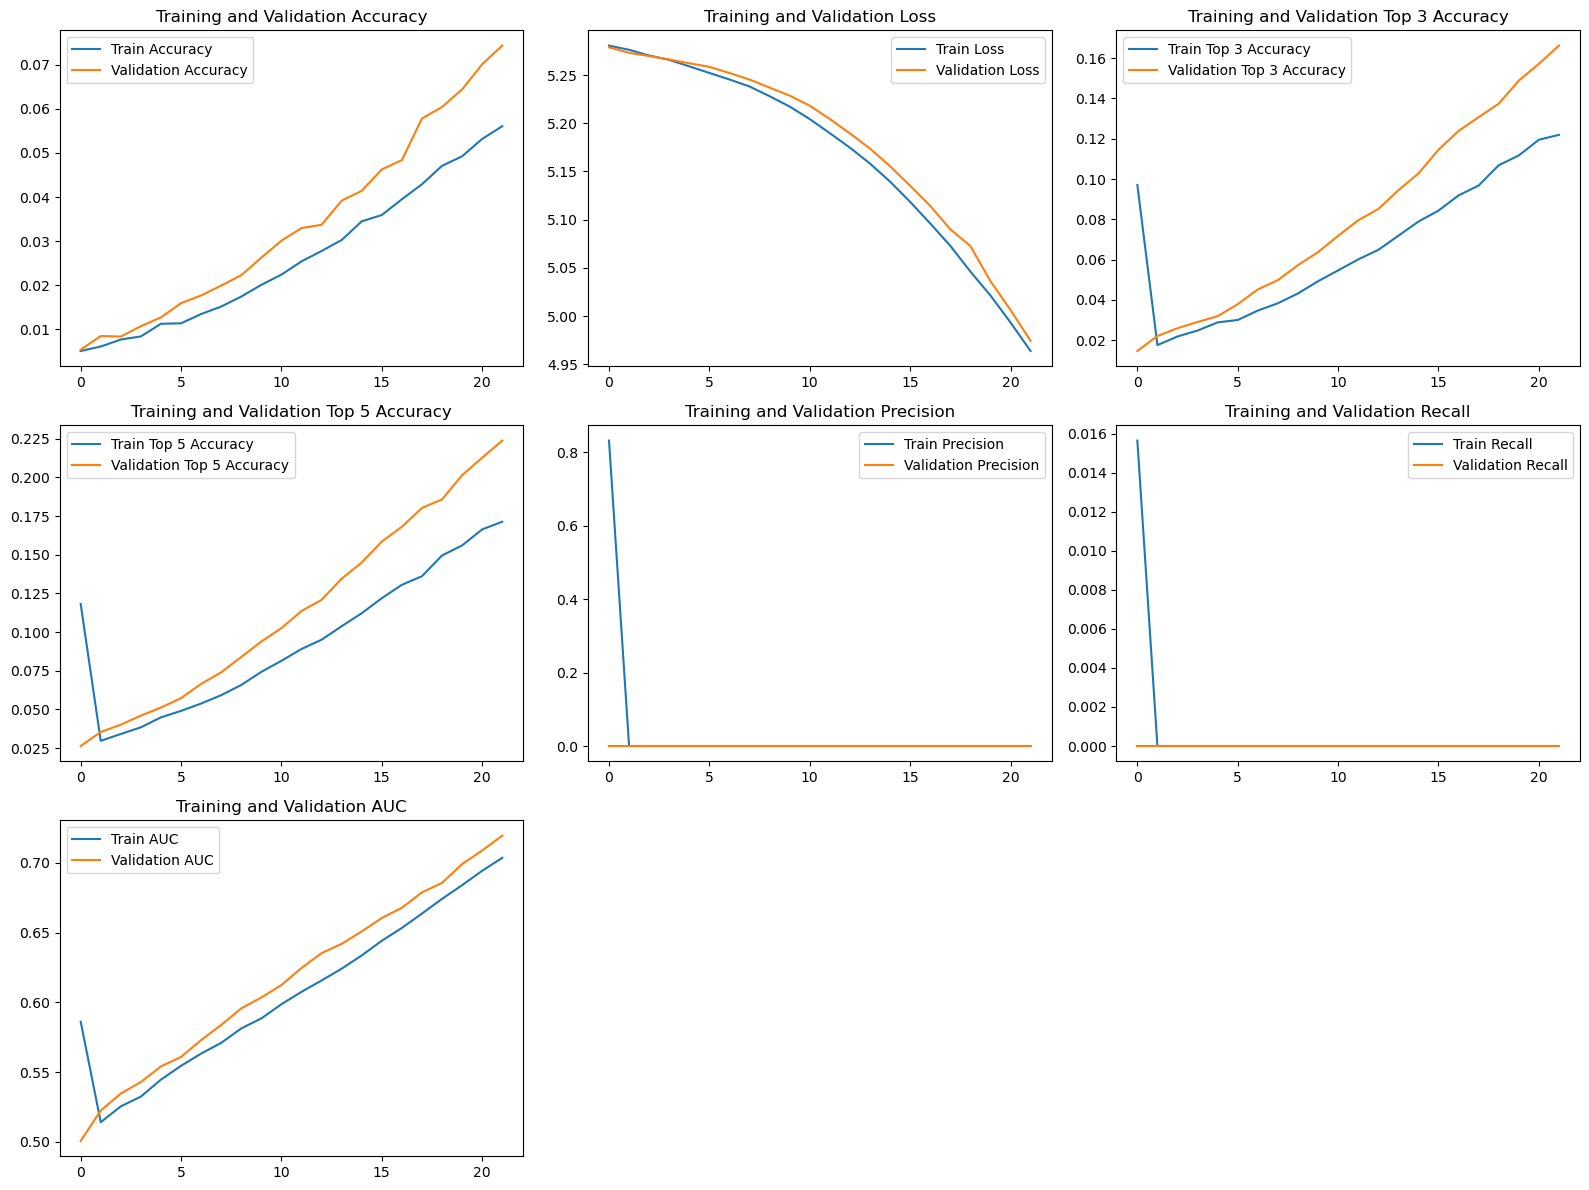

In [71]:
# Train EfficientNet
print("Training model: EfficientNet")
histories_def_hp['EfficientNet'] = run_model_pipeline(create_efficientnet_model, 'EfficientNet', default_hyperparams, input_shape, num_classes, train_generator, test_generator, epochs)


In [72]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 12018.855 seconds
Execution time: 200.314 minutes
CPU Execution time: 6332.312 seconds
CPU Execution time: 105.539 minutes


### Train Model 8 - Inceptionv3

In [73]:
st1 = time.time()
st2 = time.process_time()

Training model: InceptionV3
Number of all layers in the feature-extractor part of the model: 311.
Number of frozen (untrainable) layers in the feature-extractor part of the model: 0.
Summary for InceptionV3:
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 111, 111, 32) 864         input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_104 (BatchN (None, 111, 111, 32) 96          conv2d_125[0][0]                 
_________________________________________________________________________________

Epoch 1/22
382/382 [==============================] - 684s 2s/step - loss: 5.3109 - categorical_accuracy: 0.0047 - accuracy: 0.0047 - top_3_acc: 0.0366 - top_5_acc: 0.0533 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5322 - val_loss: 5.2816 - val_categorical_accuracy: 0.0056 - val_accuracy: 0.0056 - val_top_3_acc: 0.0165 - val_top_5_acc: 0.0259 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5065

Epoch 00001: val_top_3_acc improved from -inf to 0.01654, saving model to InceptionV3_fold_1.h5
Epoch 2/22
382/382 [==============================] - 568s 1s/step - loss: 5.3059 - categorical_accuracy: 0.0050 - accuracy: 0.0050 - top_3_acc: 0.0163 - top_5_acc: 0.0270 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5018 - val_loss: 5.2779 - val_categorical_accuracy: 0.0047 - val_accuracy: 0.0047 - val_top_3_acc: 0.0174 - val_top_5_acc: 0.0270 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5111

Epoch 00002: val_top_3_acc improved from 0.01654


Epoch 00016: val_top_3_acc improved from 0.05285 to 0.05646, saving model to InceptionV3_fold_1.h5
Epoch 17/22
382/382 [==============================] - 516s 1s/step - loss: 5.2399 - categorical_accuracy: 0.0121 - accuracy: 0.0121 - top_3_acc: 0.0306 - top_5_acc: 0.0477 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5530 - val_loss: 5.2212 - val_categorical_accuracy: 0.0228 - val_accuracy: 0.0228 - val_top_3_acc: 0.0618 - val_top_5_acc: 0.0936 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6044

Epoch 00017: val_top_3_acc improved from 0.05646 to 0.06181, saving model to InceptionV3_fold_1.h5
Epoch 18/22
382/382 [==============================] - 521s 1s/step - loss: 5.2331 - categorical_accuracy: 0.0129 - accuracy: 0.0129 - top_3_acc: 0.0327 - top_5_acc: 0.0514 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5582 - val_loss: 5.2126 - val_categorical_accuracy: 0.0256 - val_accuracy: 0.0256 - val_top_3_acc: 0.0679 - val_top_5_acc: 0.1007 - val_precision

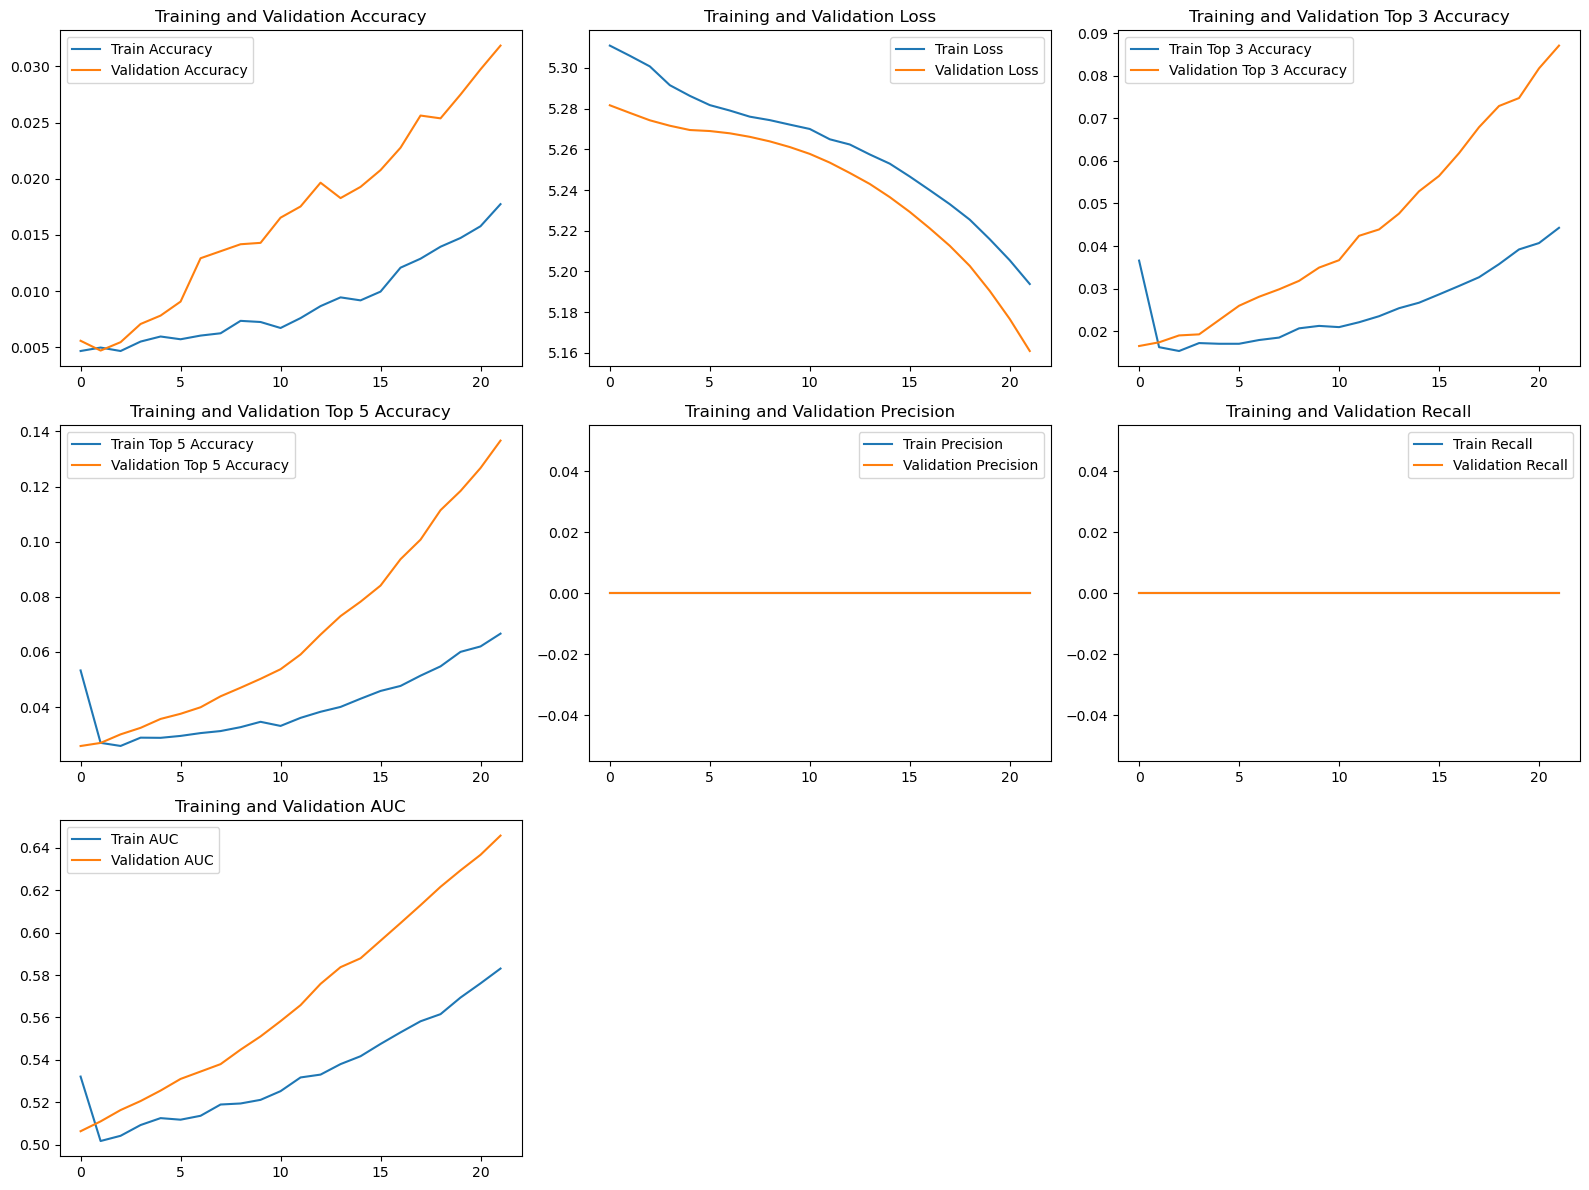

In [74]:
# Train InceptionV3
print("Training model: InceptionV3")
histories_def_hp['Inceptionv3'] = run_model_pipeline(create_inceptionv3_model, 'InceptionV3', default_hyperparams, input_shape, num_classes, train_generator, test_generator, epochs)

In [75]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 12005.312 seconds
Execution time: 200.089 minutes
CPU Execution time: 6746.281 seconds
CPU Execution time: 112.438 minutes


In [76]:
# Make separate charts for visibility

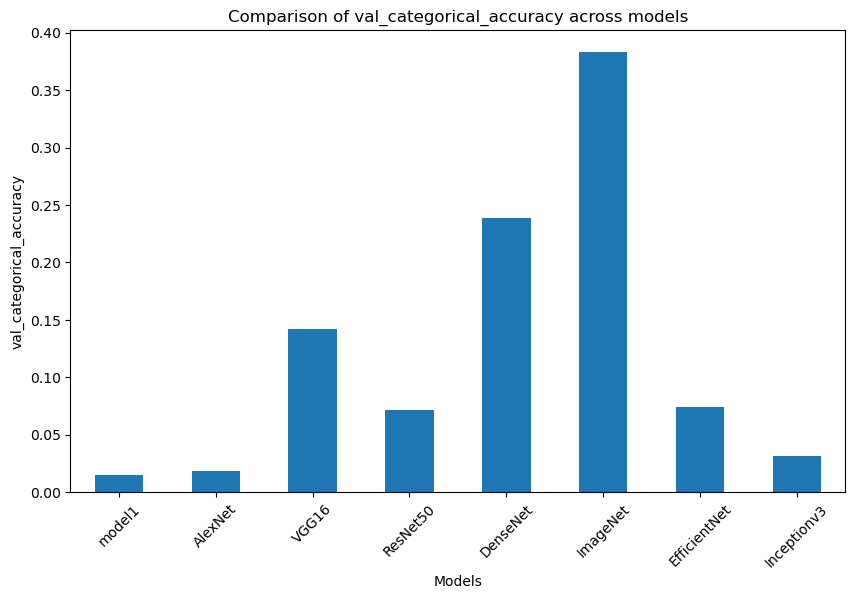

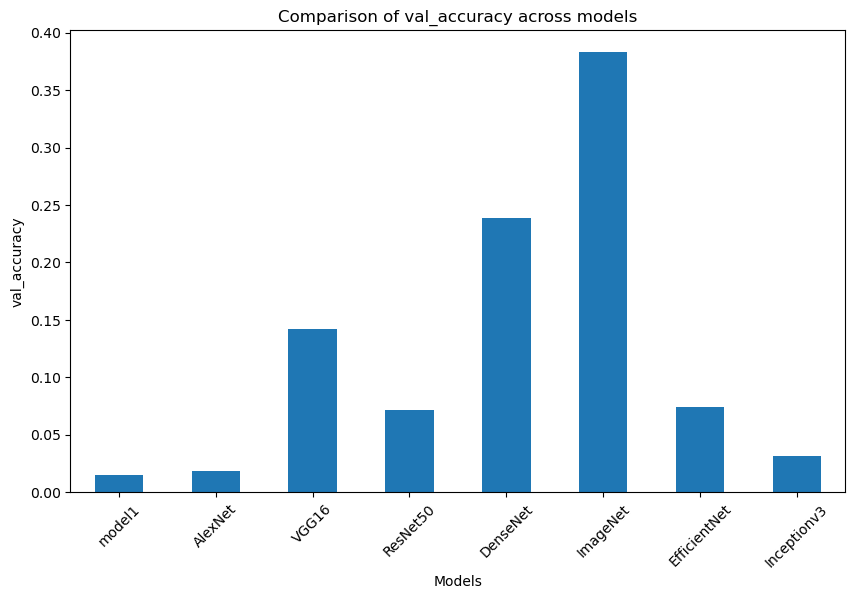

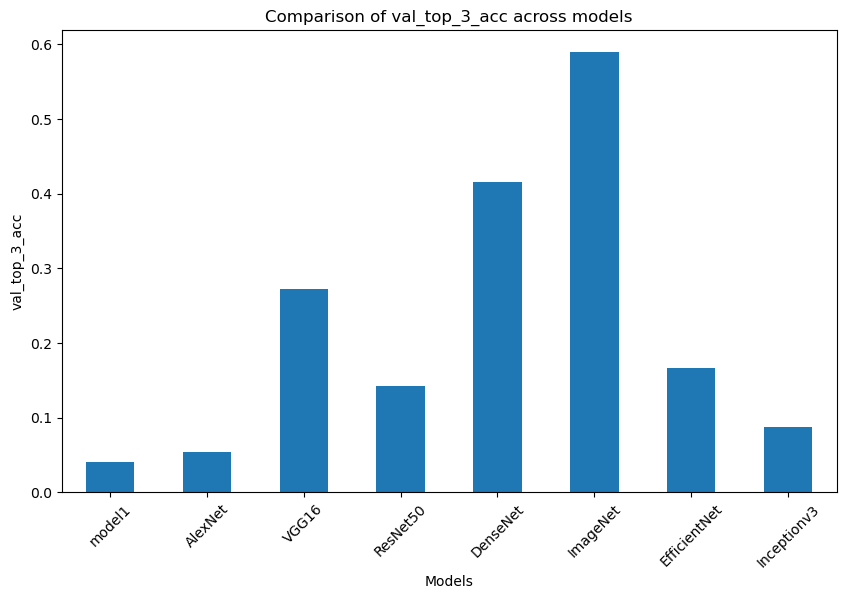

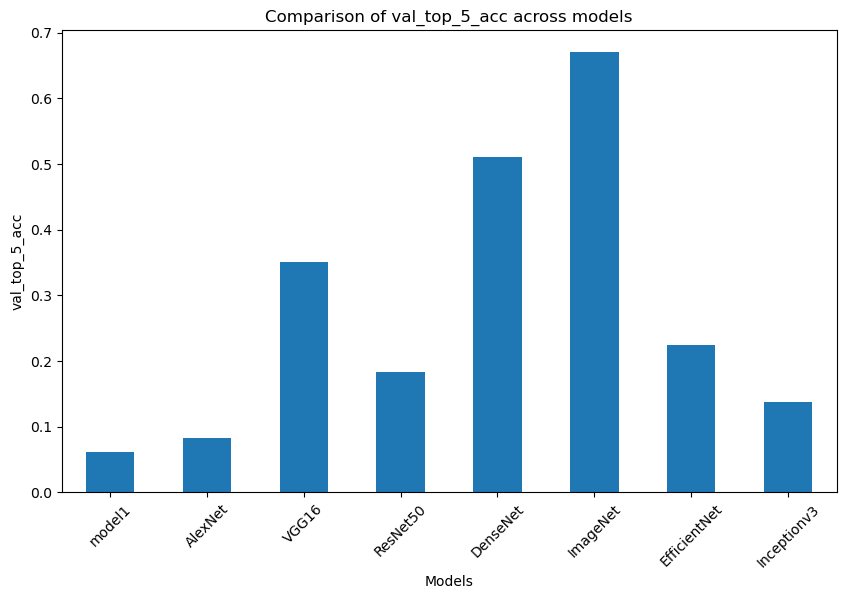

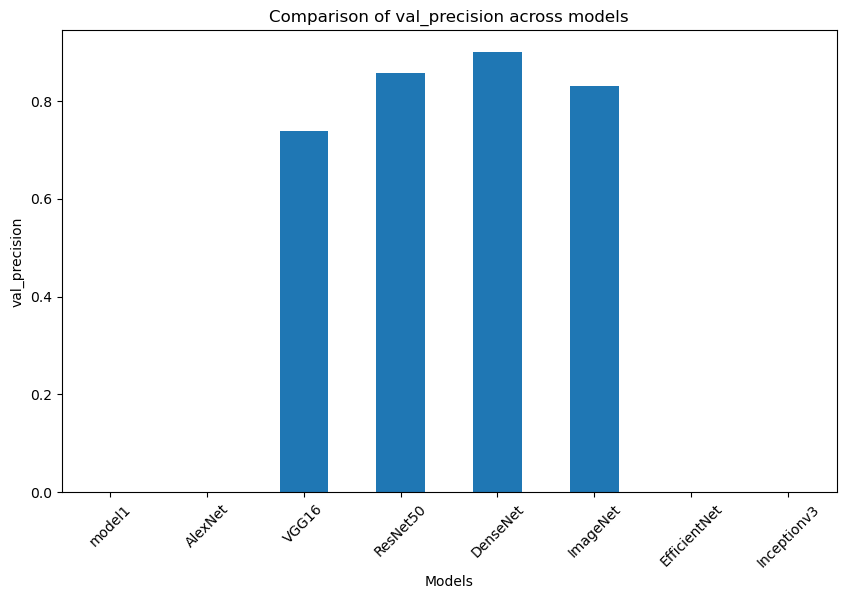

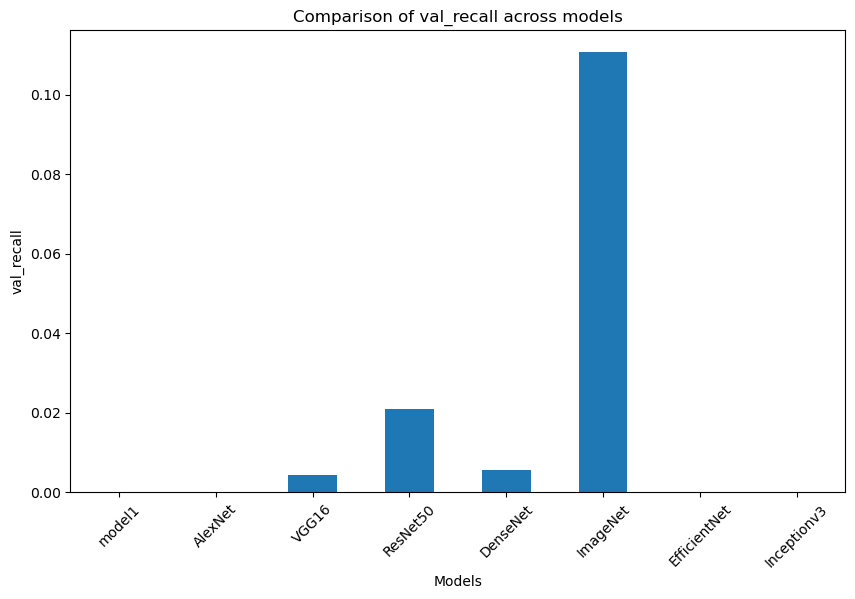

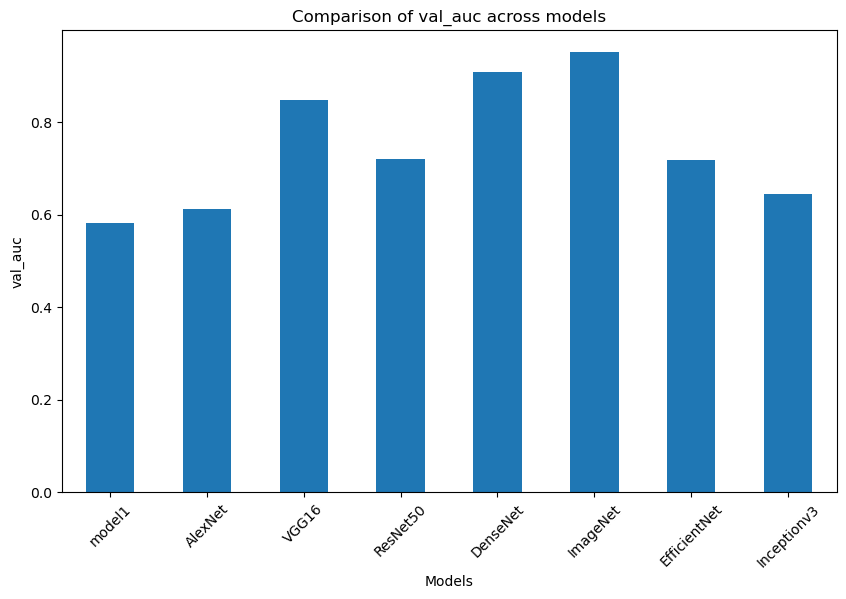

In [77]:
metrics_def = ['val_categorical_accuracy', 'val_accuracy', 'val_top_3_acc', 'val_top_5_acc', 'val_precision', 'val_recall', 'val_auc']

# Extract the final value of each metric for each model
final_results_def = {}

for model_name, history in histories_def_hp.items():
    final_results_def[model_name] = {metric: history[metric][-1] for metric in metrics_def}
df = pd.DataFrame(final_results_def)

# Plot each metric as a bar chart
for metric in metrics_def:
    plt.figure(figsize=(10, 6))
    df.loc[metric].plot(kind='bar', title=f'Comparison of {metric} across models')
    plt.ylabel(metric)
    plt.xlabel('Models')
    plt.xticks(rotation=45)
    plt.show()

In [78]:
# List of metrics to extract for both train and validation
metrics_def_train = ['categorical_accuracy', 'accuracy', 'top_3_acc', 'top_5_acc', 'precision', 'recall', 'auc']
metrics_def_val = ['val_categorical_accuracy', 'val_accuracy', 'val_top_3_acc', 'val_top_5_acc', 'val_precision', 'val_recall', 'val_auc']

# Extract the final value of each metric for both training and validation for each model
final_results_train_def = {}
final_results_val_def = {}

for model_name, history in histories_def_hp.items():
    final_results_train_def[model_name] = {metric: history[metric][-1] for metric in metrics_def_train}
    final_results_val_def[model_name] = {metric: history[metric][-1] for metric in metrics_def_val}

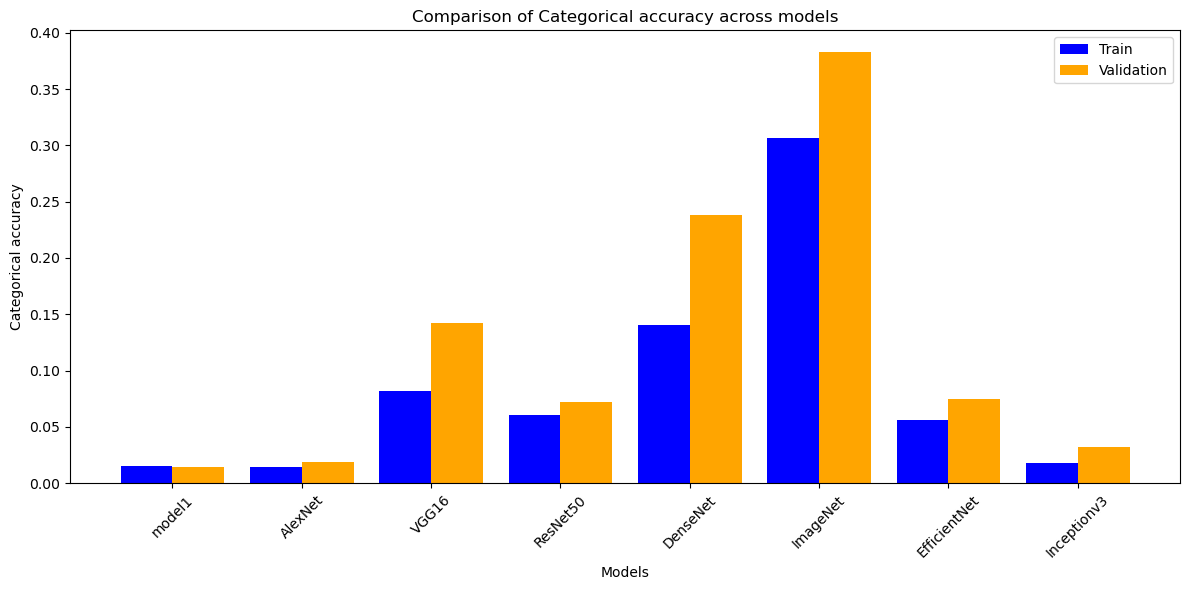

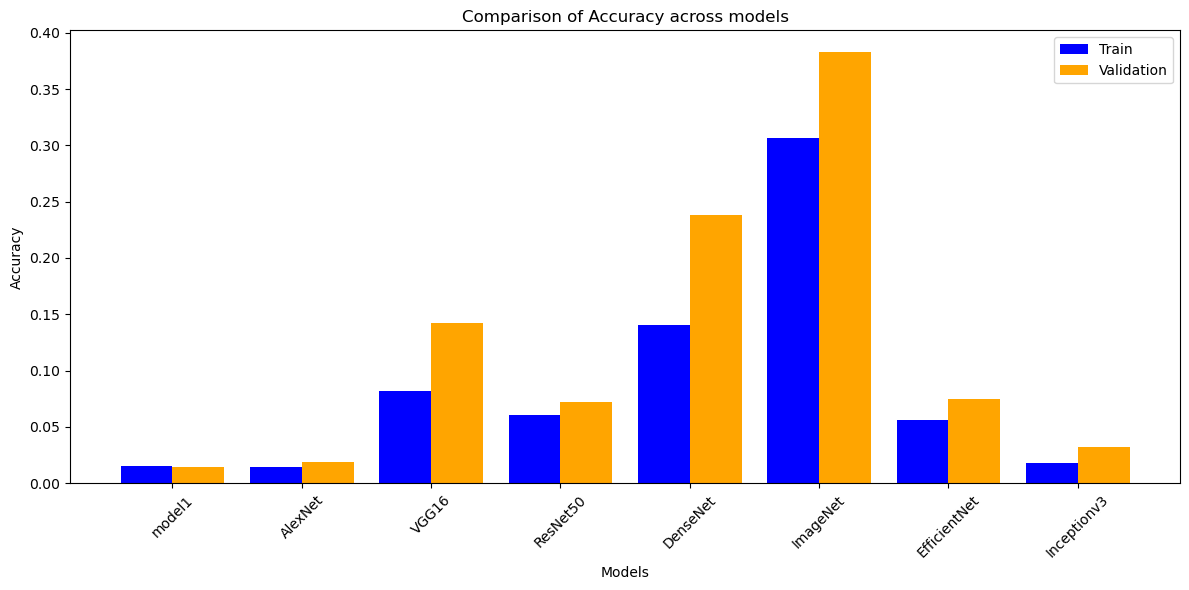

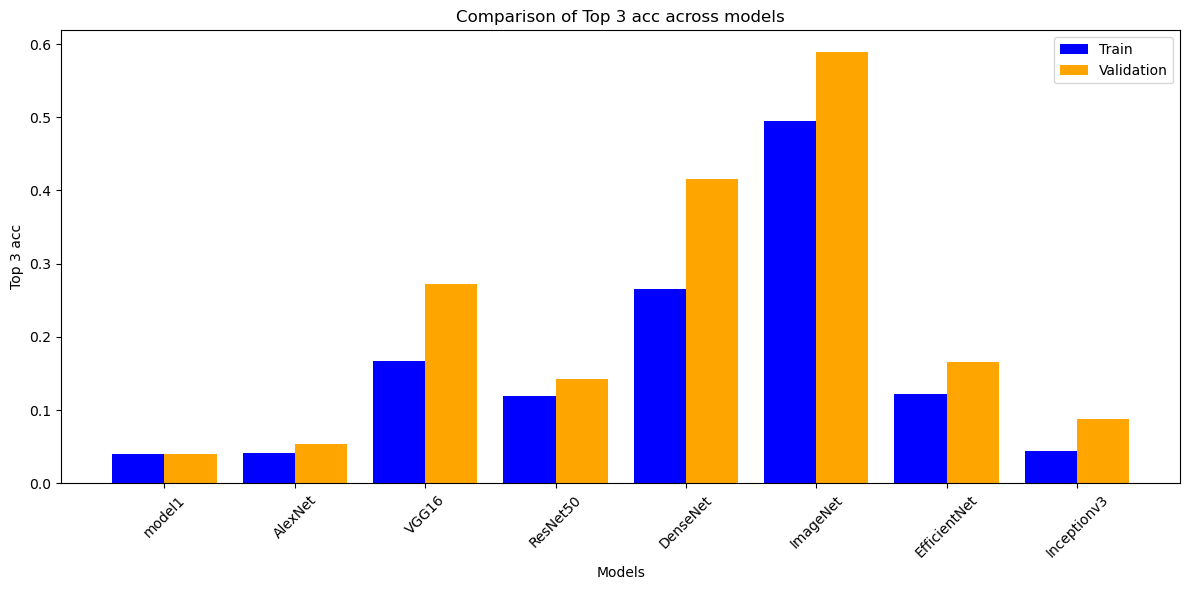

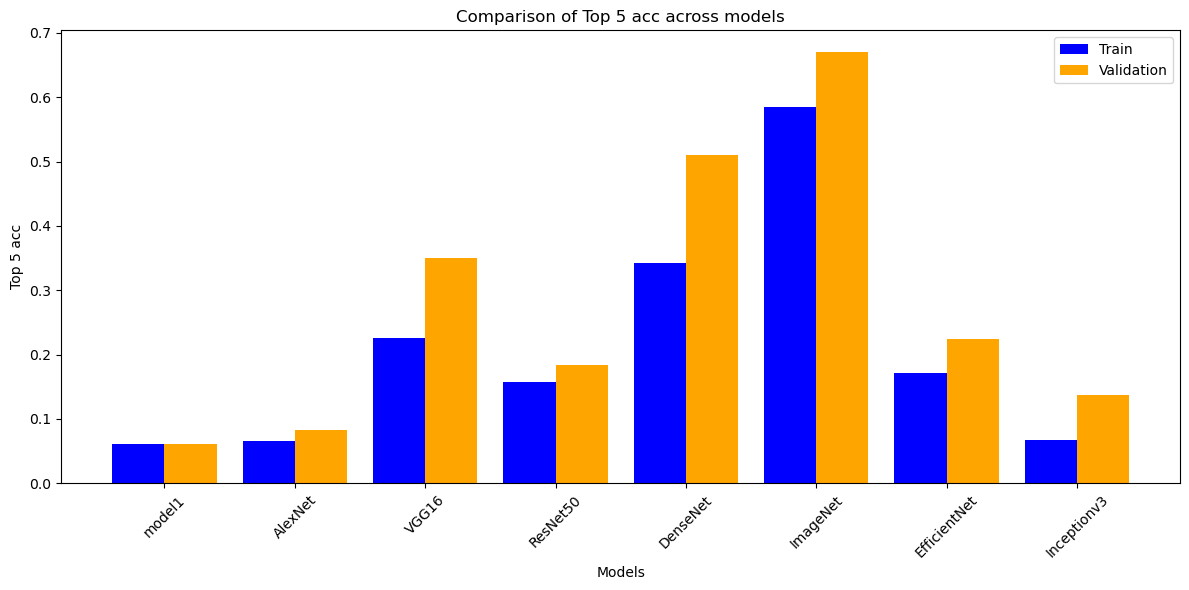

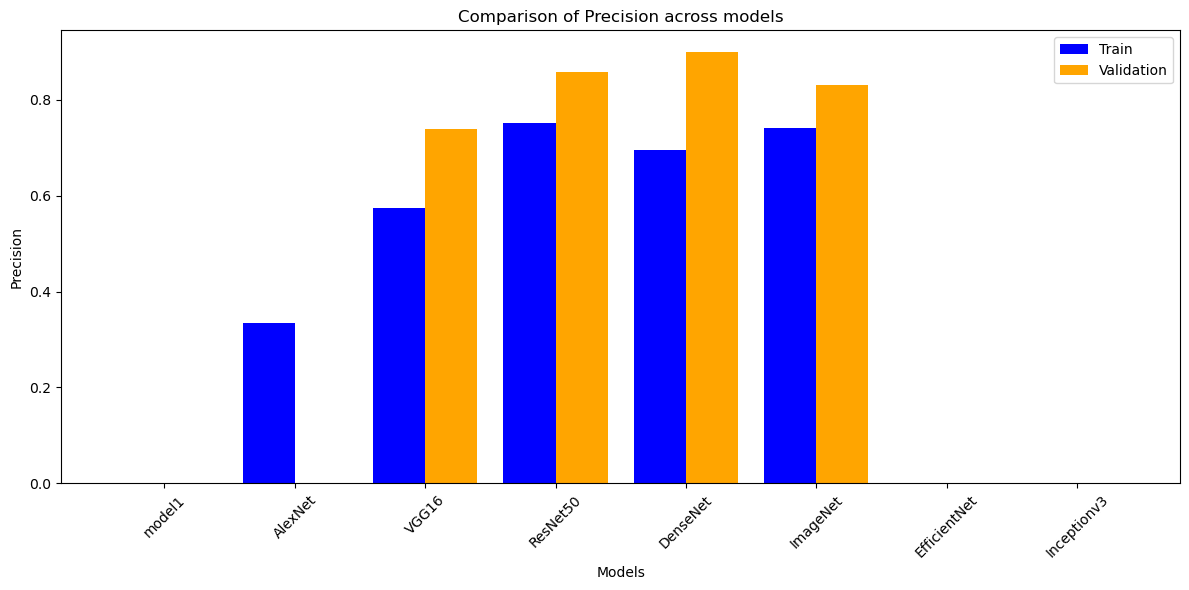

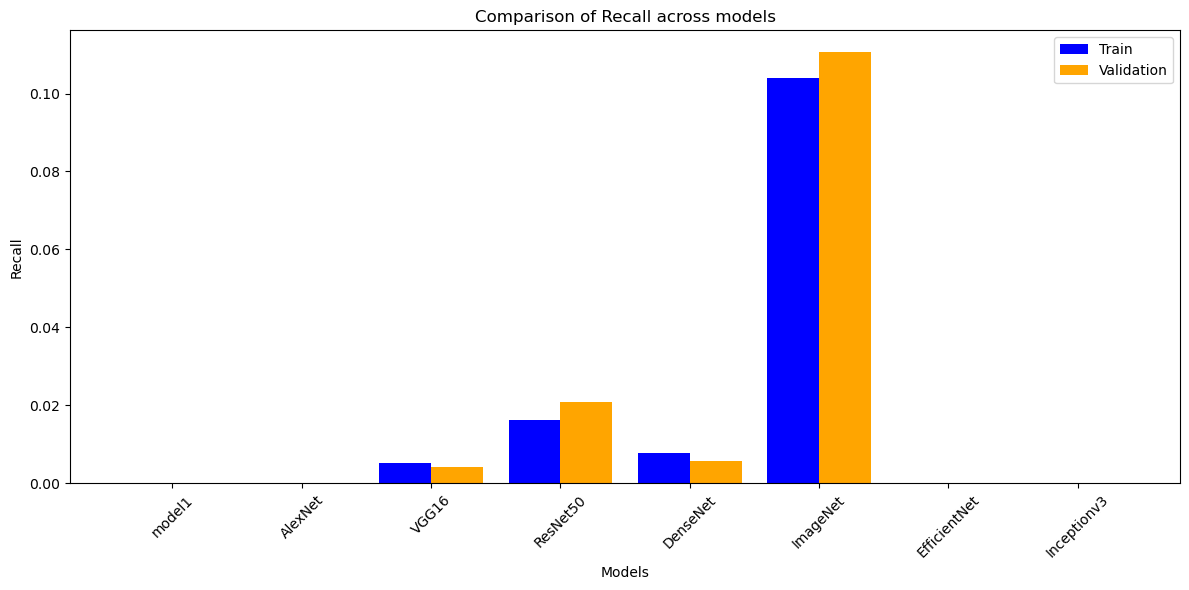

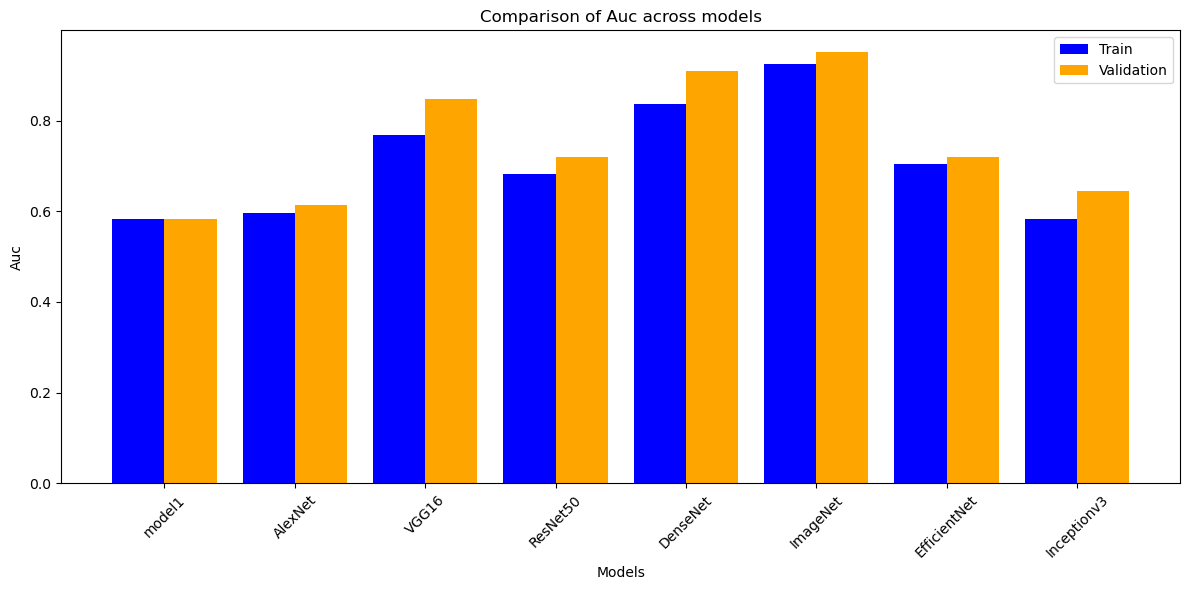

In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert the results to pandas DataFrames for easier plotting
df_train = pd.DataFrame(final_results_train_def)
df_val = pd.DataFrame(final_results_val_def)

# Plot each metric with double stacked bars (train in blue, val in orange)
for metric_train, metric_val in zip(metrics_def_train, metrics_def_val):
    plt.figure(figsize=(12, 6))
    
    # Plot train metrics
    width = 0.4  # Bar width
    bar_train = np.arange(len(df_train.columns))
    
    plt.bar(bar_train, df_train.loc[metric_train], width=width, label='Train', color='blue', align='center')
    
    # Plot validation metrics (shifted by width for side-by-side effect)
    bar_val = [i + width for i in bar_train]
    plt.bar(bar_val, df_val.loc[metric_val], width=width, label='Validation', color='orange', align='center')

    # Add labels, title, and legend
    plt.xlabel('Models')
    plt.ylabel(metric_train.replace('_', ' ').capitalize())
    plt.title(f'Comparison of {metric_train.replace("_", " ").capitalize()} across models')
    
    # Show model names as ticks
    plt.xticks(bar_train + width/2, df_train.columns, rotation=45)
    
    # Add legend
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


In [82]:
end = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print('Start time: ',start)
print('End time: ', end)

Start time:  23/10/2024 22:57:37
End time:  25/10/2024 09:50:14


## With best hyper parameters

In [83]:
histories_best_hp = {}

### Train Model1 (with calculated optimal hyper parameters)

In [84]:
st1 = time.time()
st2 = time.process_time()

Training model: model1
Summary for model1:
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_219 (Conv2D)          (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_221 

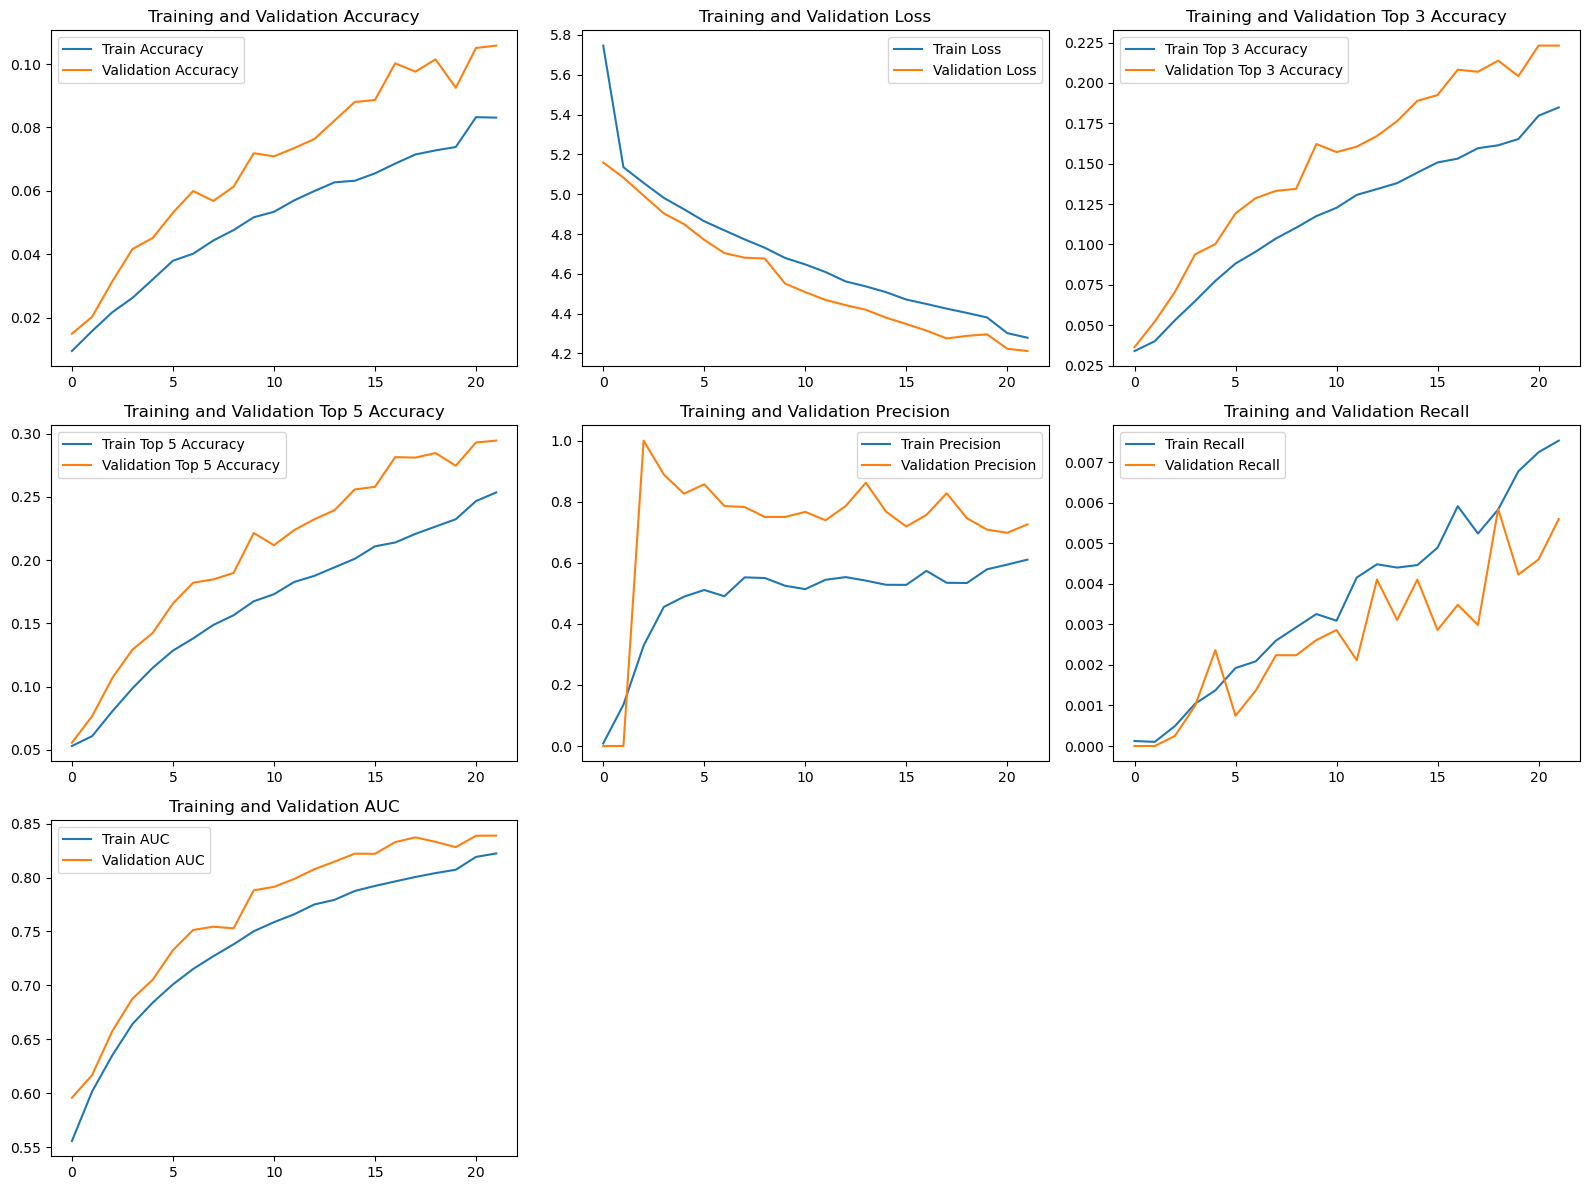

In [85]:
# Model bil-sayf par Salim
# Train model1
print("Training model: model1")
histories_best_hp['model1'] = run_model_pipeline(create_model1, 'model1', best_params, input_shape, num_classes, train_generator, test_generator, epochs)


In [86]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 11118.683 seconds
Execution time: 185.311 minutes
CPU Execution time: 5368.312 seconds
CPU Execution time: 89.472 minutes


### Train Model 2 - AlexNet (with calculated optimal hyper parameters)

In [87]:
st1 = time.time()
st2 = time.process_time()

Training model: AlexNet
Summary for AlexNet:
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 54, 54, 96)        34944     
_________________________________________________________________
spatial_dropout2d_16 (Spatia (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
batch_normalization_198 (Bat (None, 26, 26, 96)        384       
_________________________________________________________________
conv2d_223 (Conv2D)          (None, 26, 26, 256)       614656    
_________________________________________________________________
spatial_dropo


Epoch 00009: val_top_3_acc improved from 0.23156 to 0.24674, saving model to AlexNet_fold_1.h5
Epoch 10/22
382/382 [==============================] - 518s 1s/step - loss: 3.5481 - categorical_accuracy: 0.1779 - accuracy: 0.1779 - top_3_acc: 0.3359 - top_5_acc: 0.4324 - precision: 0.5511 - recall: 0.0415 - auc: 0.8875 - val_loss: 3.9001 - val_categorical_accuracy: 0.1410 - val_accuracy: 0.1410 - val_top_3_acc: 0.2762 - val_top_5_acc: 0.3554 - val_precision: 0.5258 - val_recall: 0.0266 - val_auc: 0.8467

Epoch 00010: val_top_3_acc improved from 0.24674 to 0.27621, saving model to AlexNet_fold_1.h5
Epoch 11/22
382/382 [==============================] - 498s 1s/step - loss: 3.3259 - categorical_accuracy: 0.2121 - accuracy: 0.2121 - top_3_acc: 0.3892 - top_5_acc: 0.4881 - precision: 0.5765 - recall: 0.0607 - auc: 0.9031 - val_loss: 3.8228 - val_categorical_accuracy: 0.1547 - val_accuracy: 0.1547 - val_top_3_acc: 0.2962 - val_top_5_acc: 0.3758 - val_precision: 0.5414 - val_recall: 0.0349 - 

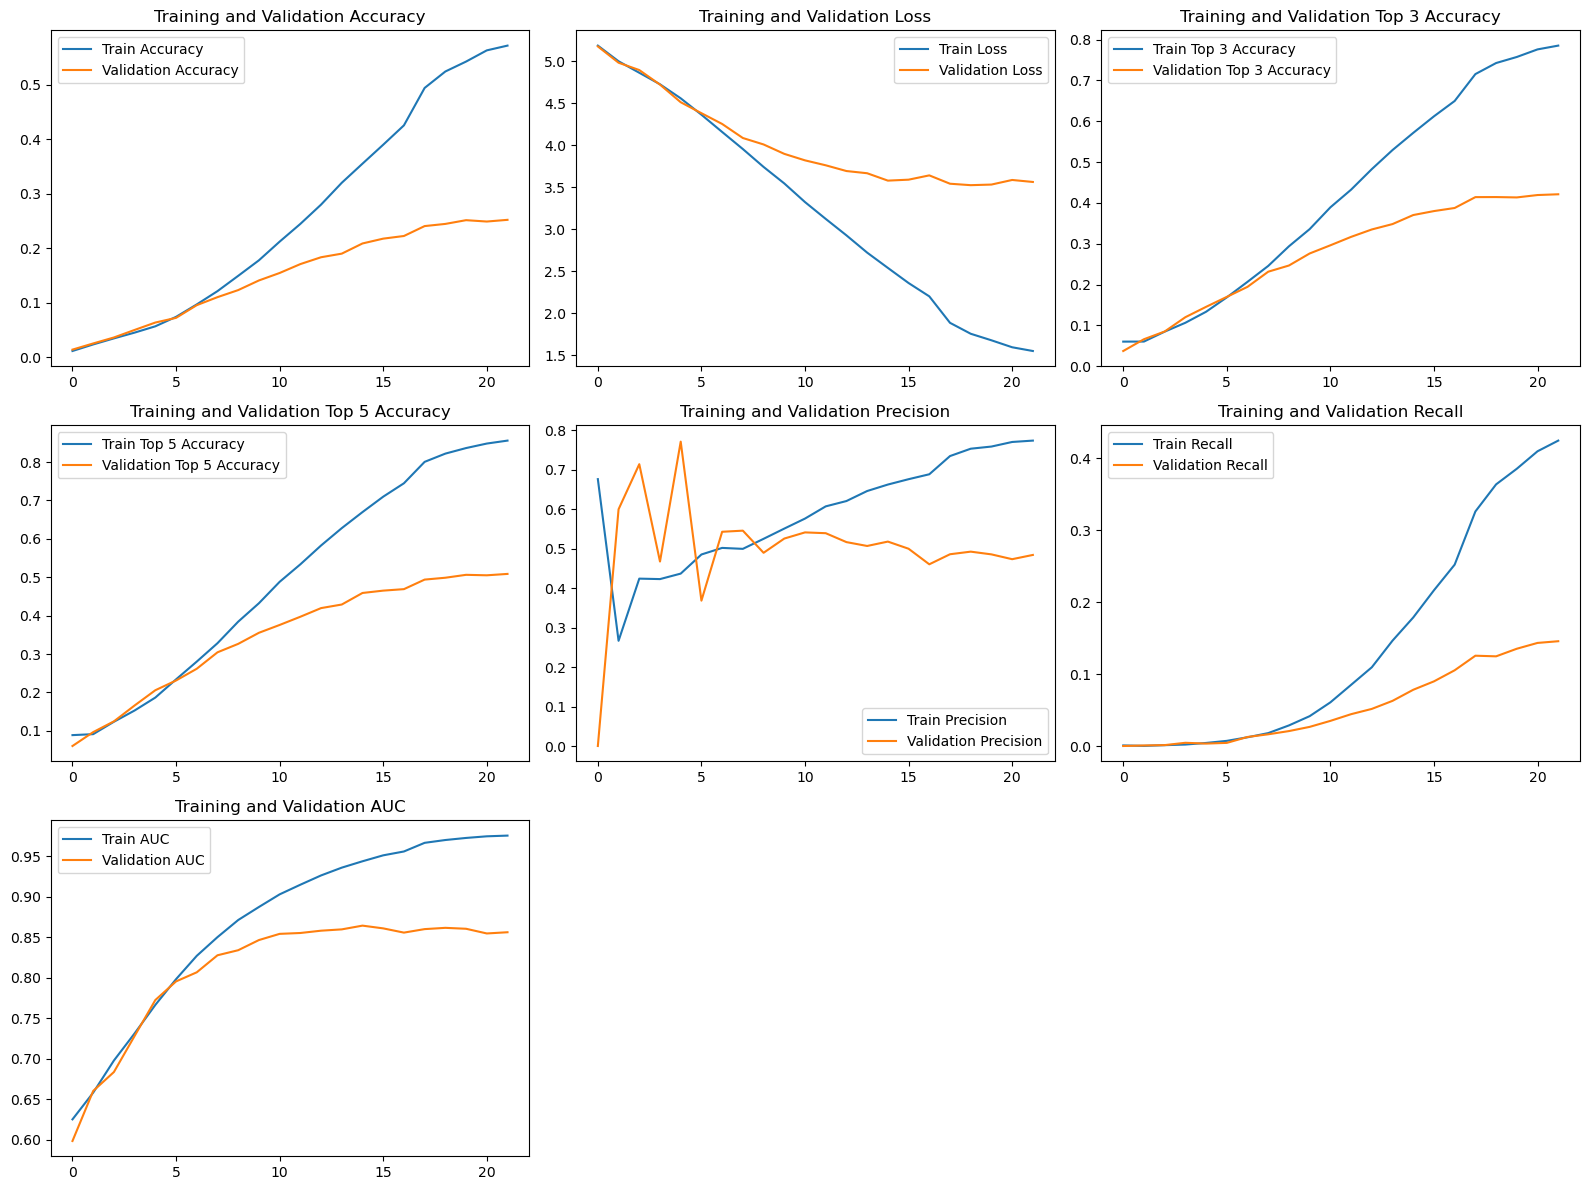

In [88]:
# Train AlexNet
print("Training model: AlexNet")
histories_best_hp['AlexNet'] = run_model_pipeline(create_alexnet_model, 'AlexNet', best_params, input_shape, num_classes, train_generator, test_generator, epochs)


In [89]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 11259.503 seconds
Execution time: 187.658 minutes
CPU Execution time: 5447.688 seconds
CPU Execution time: 90.795 minutes


### Train Model 3 - VGG16 (with calculated optimal hyper parameters)

In [90]:
st1 = time.time()
st2 = time.process_time()

In [91]:
# Train VGG16
print("Training model: VGG16")
histories_best_hp['VGG16'] = run_model_pipeline(create_vgg16_model, 'VGG16', best_params, input_shape, num_classes, train_generator, test_generator, epochs)

Training model: VGG16
Number of all layers in a feature-extractor part of model: 19.
Number of freezed (untrainable) layers in a feature-extractor part of model: 0.
Summary for VGG16:
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (Cast_22:0) = ] [[nan nan nan...]...] [y (Cast_24/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_207/assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_less_equal_1/Assert/AssertGuard/pivot_f/_239/_103]]
  (1) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (Cast_22:0) = ] [[nan nan nan...]...] [y (Cast_24/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_207/assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_17202579]

Function call stack:
train_function -> train_function


In [92]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 424.300 seconds
Execution time: 7.072 minutes
CPU Execution time: 16.469 seconds
CPU Execution time: 0.274 minutes


### Train Model 4 - ResNet50 (with calculated optimal hyper parameters)

In [93]:
st1 = time.time()
st2 = time.process_time()

Training model: ResNet50
Number of all layers in the feature-extractor part of the model: 175.
Number of frozen (untrainable) layers in the feature-extractor part of the model: 0.
Summary for ResNet50:
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_19[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
_______________________________________________________________________________________

Epoch 1/22
382/382 [==============================] - 529s 1s/step - loss: 5.1885 - categorical_accuracy: 0.0100 - accuracy: 0.0100 - top_3_acc: 0.1155 - top_5_acc: 0.1442 - precision: 0.2381 - recall: 0.0198 - auc: 0.6196 - val_loss: 5.2814 - val_categorical_accuracy: 0.0085 - val_accuracy: 0.0085 - val_top_3_acc: 0.0199 - val_top_5_acc: 0.0310 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5075

Epoch 00001: val_top_3_acc improved from -inf to 0.01990, saving model to ResNet50_fold_1.h5


C:\anaconda3\envs\dlproj\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/22
382/382 [==============================] - 515s 1s/step - loss: 4.9848 - categorical_accuracy: 0.0203 - accuracy: 0.0203 - top_3_acc: 0.0524 - top_5_acc: 0.0806 - precision: 0.2667 - recall: 1.6372e-04 - auc: 0.6628 - val_loss: 5.2660 - val_categorical_accuracy: 0.0067 - val_accuracy: 0.0067 - val_top_3_acc: 0.0194 - val_top_5_acc: 0.0362 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5499

Epoch 00002: val_top_3_acc did not improve from 0.01990
Epoch 3/22
382/382 [==============================] - 522s 1s/step - loss: 4.5434 - categorical_accuracy: 0.0399 - accuracy: 0.0399 - top_3_acc: 0.0990 - top_5_acc: 0.1503 - precision: 0.3235 - recall: 6.7534e-04 - auc: 0.7815 - val_loss: 4.9588 - val_categorical_accuracy: 0.0364 - val_accuracy: 0.0364 - val_top_3_acc: 0.0915 - val_top_5_acc: 0.1397 - val_precision: 0.2170 - val_recall: 0.0029 - val_auc: 0.7214

Epoch 00003: val_top_3_acc improved from 0.01990 to 0.09153, saving model to ResNet50_fold_1.h5
Epoch 4/

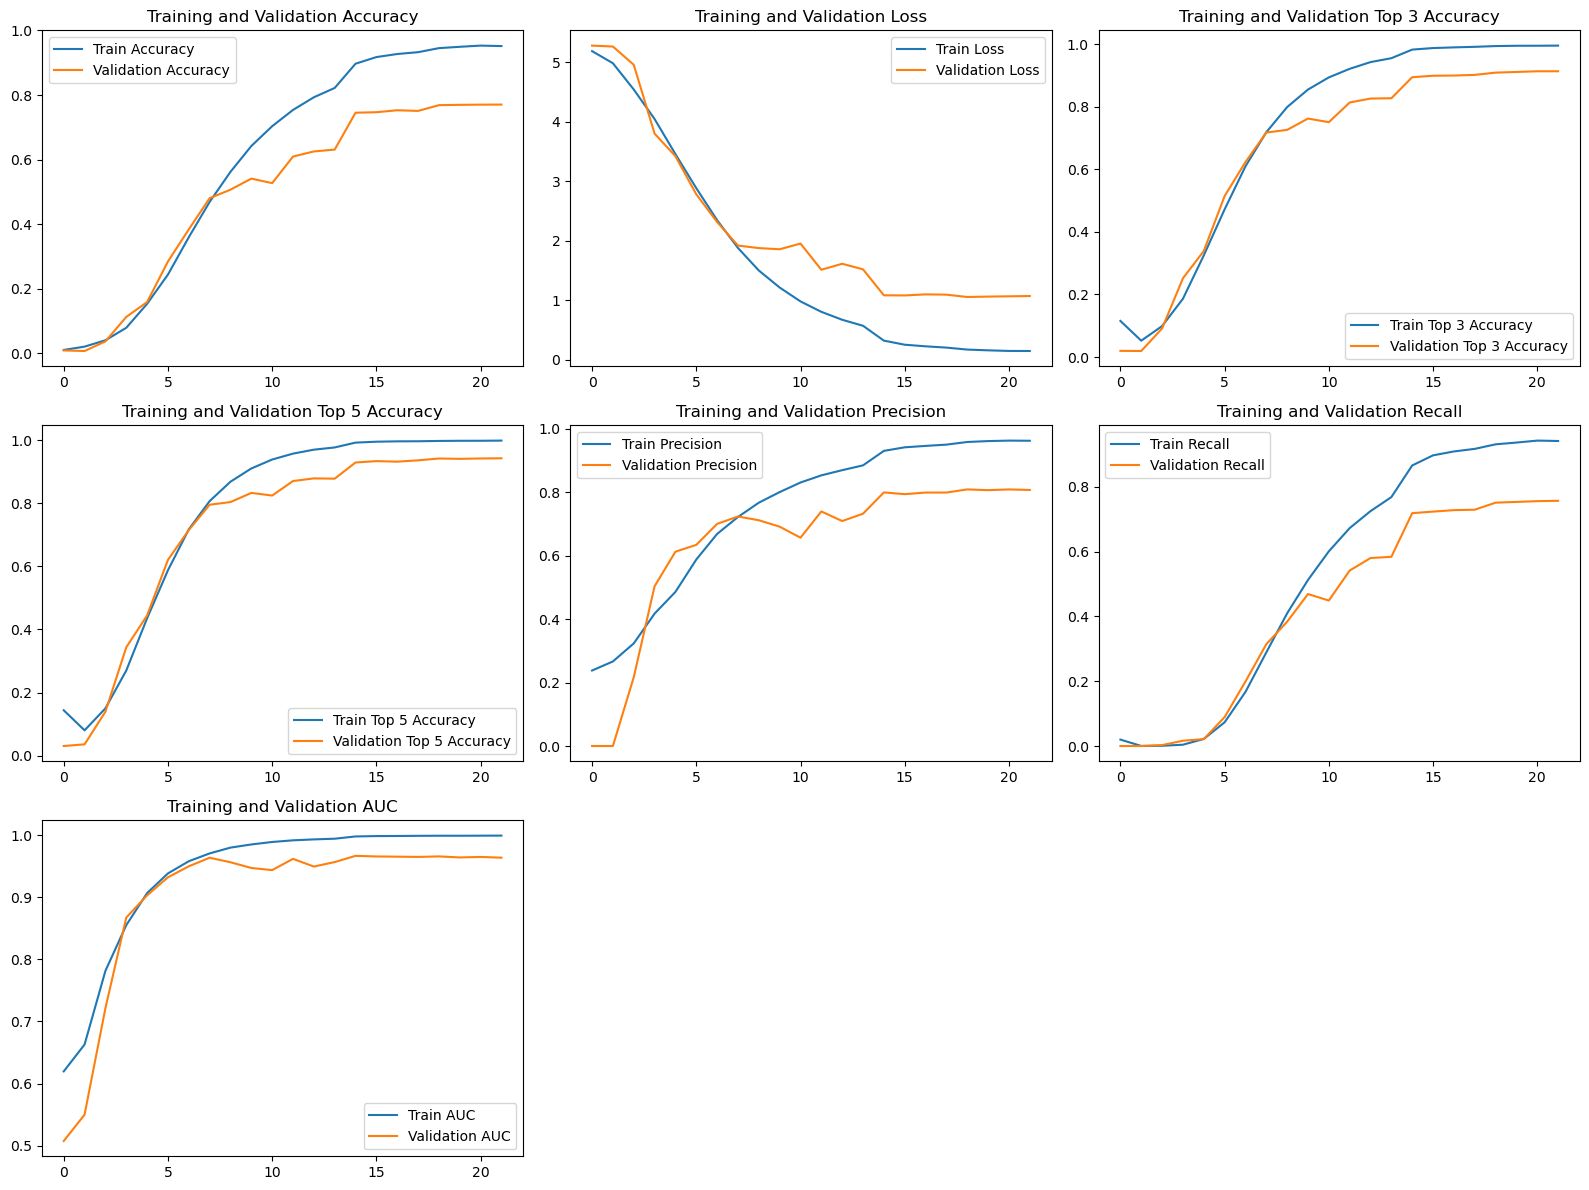

In [94]:
# Train ResNet50
print("Training model: ResNet50")
histories_best_hp['ResNet50'] = run_model_pipeline(create_resnet50_model, 'ResNet50', best_params, input_shape, num_classes, train_generator, test_generator, epochs)


In [95]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 11166.939 seconds
Execution time: 186.116 minutes
CPU Execution time: 6613.453 seconds
CPU Execution time: 110.224 minutes


### Train Model 5 - DenseNet (with calculated optimal hyper parameters)

In [96]:
# try with higher learning rates explicitly

In [97]:
st1 = time.time()
st2 = time.process_time()

Training model: DenseNet
Summary for DenseNet:
Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_20[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________

Epoch 1/22
382/382 [==============================] - 538s 1s/step - loss: 5.3407 - categorical_accuracy: 0.0076 - accuracy: 0.0076 - top_3_acc: 0.1449 - top_5_acc: 0.1584 - precision: 0.7878 - recall: 0.1070 - auc: 0.6155 - val_loss: 5.2754 - val_categorical_accuracy: 0.0085 - val_accuracy: 0.0085 - val_top_3_acc: 0.0203 - val_top_5_acc: 0.0320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5161

Epoch 00001: val_top_3_acc improved from -inf to 0.02027, saving model to DenseNet_fold_1.h5
Epoch 2/22
382/382 [==============================] - 514s 1s/step - loss: 5.2753 - categorical_accuracy: 0.0083 - accuracy: 0.0083 - top_3_acc: 0.0199 - top_5_acc: 0.0314 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5139 - val_loss: 5.2741 - val_categorical_accuracy: 0.0085 - val_accuracy: 0.0085 - val_top_3_acc: 0.0203 - val_top_5_acc: 0.0320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5181

Epoch 00002: val_top_3_acc did not improve from 0.02027
Epo

Epoch 17/22
382/382 [==============================] - 516s 1s/step - loss: 1.2235 - categorical_accuracy: 0.6433 - accuracy: 0.6433 - top_3_acc: 0.8499 - top_5_acc: 0.9068 - precision: 0.8069 - recall: 0.5171 - auc: 0.9843 - val_loss: 1.8755 - val_categorical_accuracy: 0.5461 - val_accuracy: 0.5461 - val_top_3_acc: 0.7510 - val_top_5_acc: 0.8152 - val_precision: 0.7067 - val_recall: 0.4547 - val_auc: 0.9456

Epoch 00017: val_top_3_acc improved from 0.71086 to 0.75103, saving model to DenseNet_fold_1.h5
Epoch 18/22
382/382 [==============================] - 513s 1s/step - loss: 0.9839 - categorical_accuracy: 0.7045 - accuracy: 0.7045 - top_3_acc: 0.8957 - top_5_acc: 0.9395 - precision: 0.8278 - recall: 0.6040 - auc: 0.9884 - val_loss: 1.7375 - val_categorical_accuracy: 0.5876 - val_accuracy: 0.5876 - val_top_3_acc: 0.7784 - val_top_5_acc: 0.8358 - val_precision: 0.7404 - val_recall: 0.5160 - val_auc: 0.9490

Epoch 00018: val_top_3_acc improved from 0.75103 to 0.77839, saving model to D

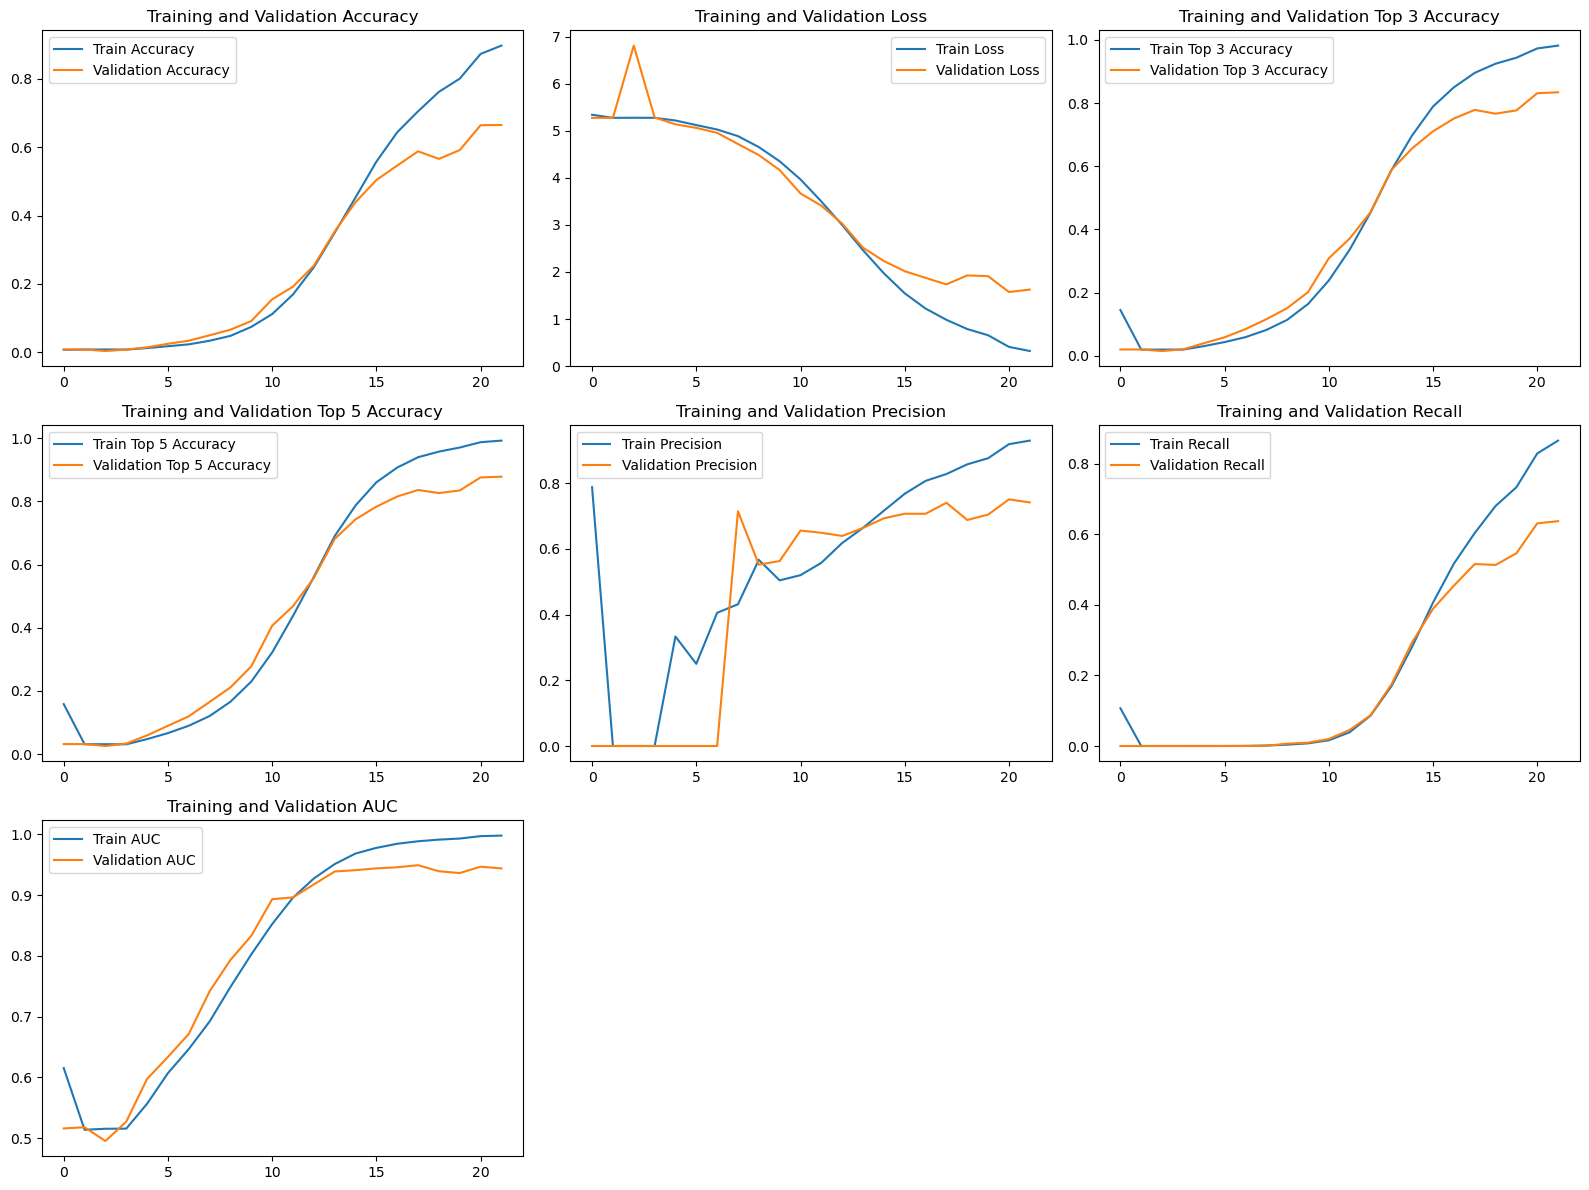

In [98]:
# Train DenseNet
print("Training model: DenseNet")
histories_best_hp['DenseNet'] = run_model_pipeline(create_densenet_model, 'DenseNet', best_params, input_shape, num_classes, train_generator, test_generator, epochs)


In [99]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 11422.318 seconds
Execution time: 190.372 minutes
CPU Execution time: 7020.641 seconds
CPU Execution time: 117.011 minutes


### Train Model 6 - ImageNet (with calculated optimal hyper parameters)

In [100]:
st1 = time.time()
st2 = time.process_time()

Training model: ImageNet
Summary for ImageNet:
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_22[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________

Epoch 1/22
382/382 [==============================] - 532s 1s/step - loss: 5.1724 - categorical_accuracy: 0.0142 - accuracy: 0.0142 - top_3_acc: 0.1490 - top_5_acc: 0.1724 - precision: 0.7377 - recall: 0.0904 - auc: 0.6582 - val_loss: 5.2824 - val_categorical_accuracy: 0.0085 - val_accuracy: 0.0085 - val_top_3_acc: 0.0193 - val_top_5_acc: 0.0303 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5053

Epoch 00001: val_top_3_acc improved from -inf to 0.01928, saving model to ImageNet_fold_1.h5
Epoch 2/22
382/382 [==============================] - 516s 1s/step - loss: 4.9830 - categorical_accuracy: 0.0288 - accuracy: 0.0288 - top_3_acc: 0.0661 - top_5_acc: 0.0955 - precision: 0.4897 - recall: 0.0015 - auc: 0.6567 - val_loss: 5.3033 - val_categorical_accuracy: 0.0057 - val_accuracy: 0.0057 - val_top_3_acc: 0.0175 - val_top_5_acc: 0.0302 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5044

Epoch 00002: val_top_3_acc did not improve from 0.01928
Epoch 3/22


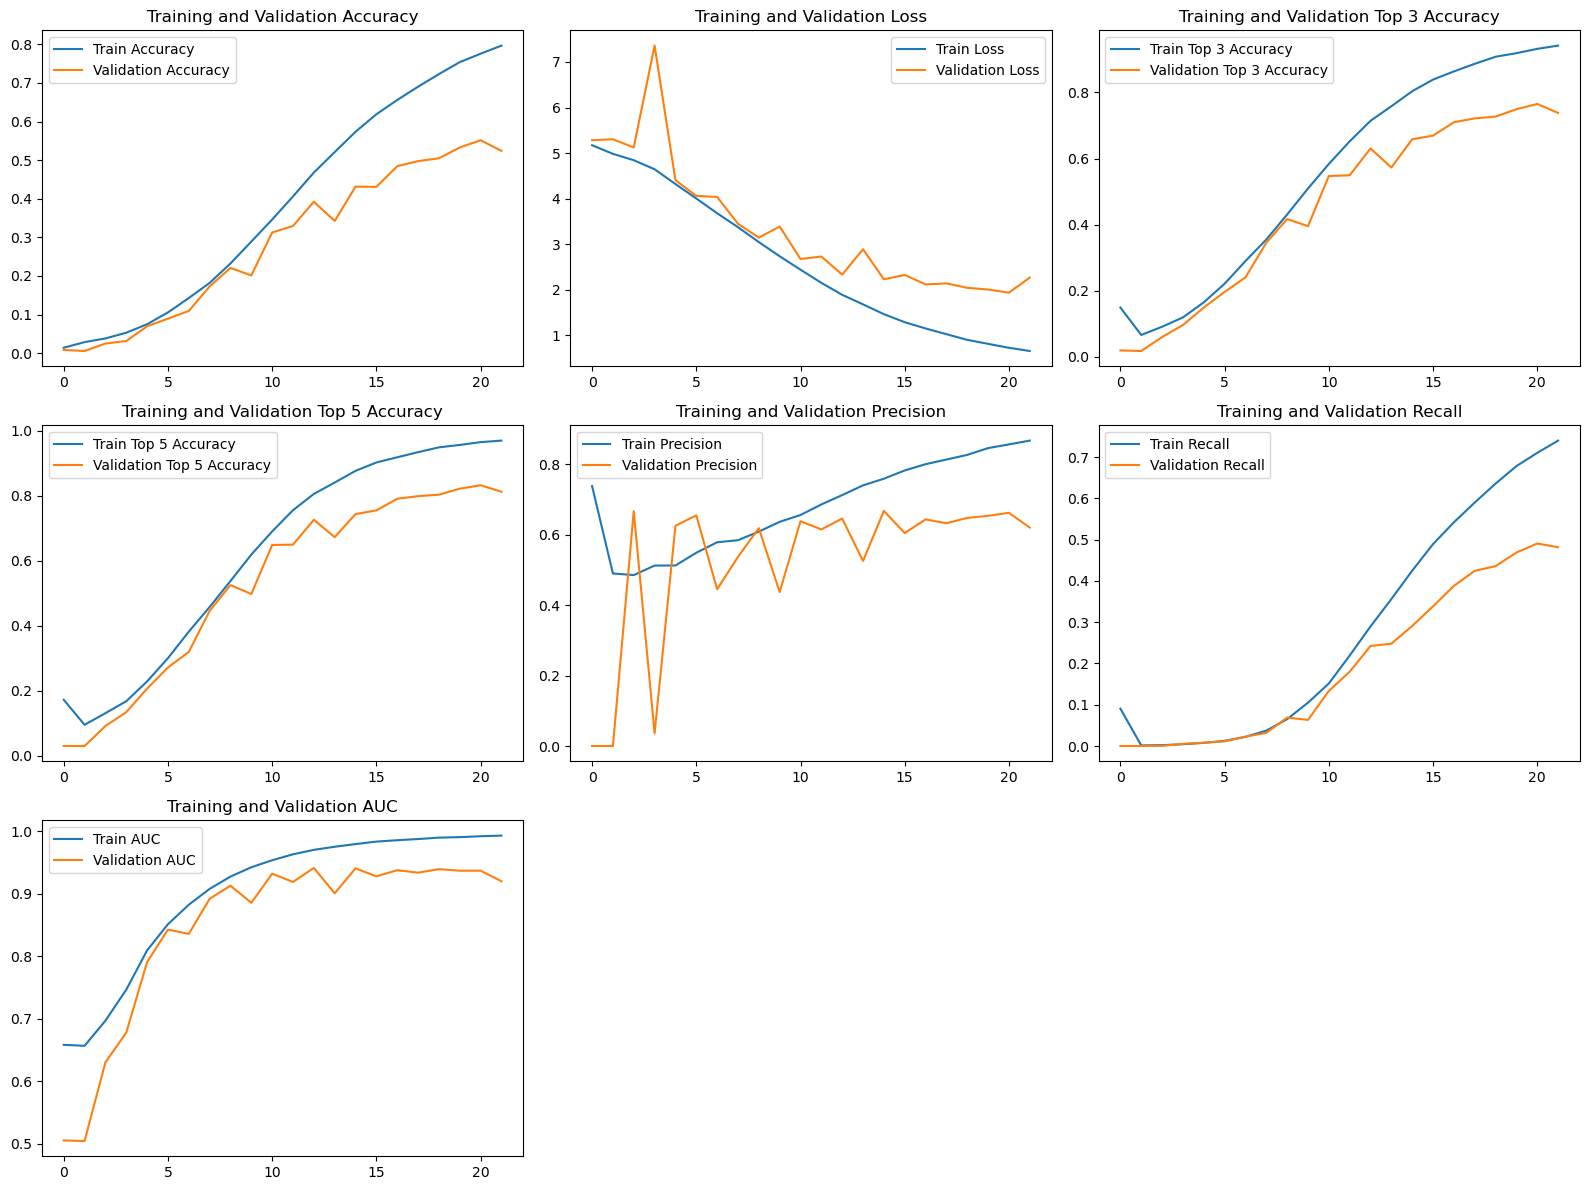

In [101]:
# Train ImageNet
print("Training model: ImageNet")
histories_best_hp['ImageNet'] = run_model_pipeline(create_imagenet_model, 'ImageNet', best_params, input_shape, num_classes, train_generator, test_generator, epochs)


In [102]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 11495.787 seconds
Execution time: 191.596 minutes
CPU Execution time: 7076.516 seconds
CPU Execution time: 117.942 minutes


### Train Model 7 - EfficientNet (with calculated optimal hyper parameters)

In [103]:
st1 = time.time()
st2 = time.process_time()

Training model: EfficientNet
Summary for EfficientNet:
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_23[0][0]                   
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            
____________________________________

Epoch 1/22
382/382 [==============================] - 539s 1s/step - loss: 2.7944 - categorical_accuracy: 0.3537 - accuracy: 0.3537 - top_3_acc: 0.5610 - top_5_acc: 0.6325 - precision: 0.6900 - recall: 0.2659 - auc: 0.9080 - val_loss: 6.0815 - val_categorical_accuracy: 0.0052 - val_accuracy: 0.0052 - val_top_3_acc: 0.0165 - val_top_5_acc: 0.0266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5016

Epoch 00001: val_top_3_acc improved from -inf to 0.01654, saving model to EfficientNet_fold_1.h5
Epoch 2/22
382/382 [==============================] - 522s 1s/step - loss: 0.7415 - categorical_accuracy: 0.7815 - accuracy: 0.7815 - top_3_acc: 0.9309 - top_5_acc: 0.9624 - precision: 0.8593 - recall: 0.7151 - auc: 0.9910 - val_loss: 5.8887 - val_categorical_accuracy: 0.1002 - val_accuracy: 0.1002 - val_top_3_acc: 0.2079 - val_top_5_acc: 0.2801 - val_precision: 0.1300 - val_recall: 0.0642 - val_auc: 0.6941

Epoch 00002: val_top_3_acc improved from 0.01654 to 0.20793, saving mod

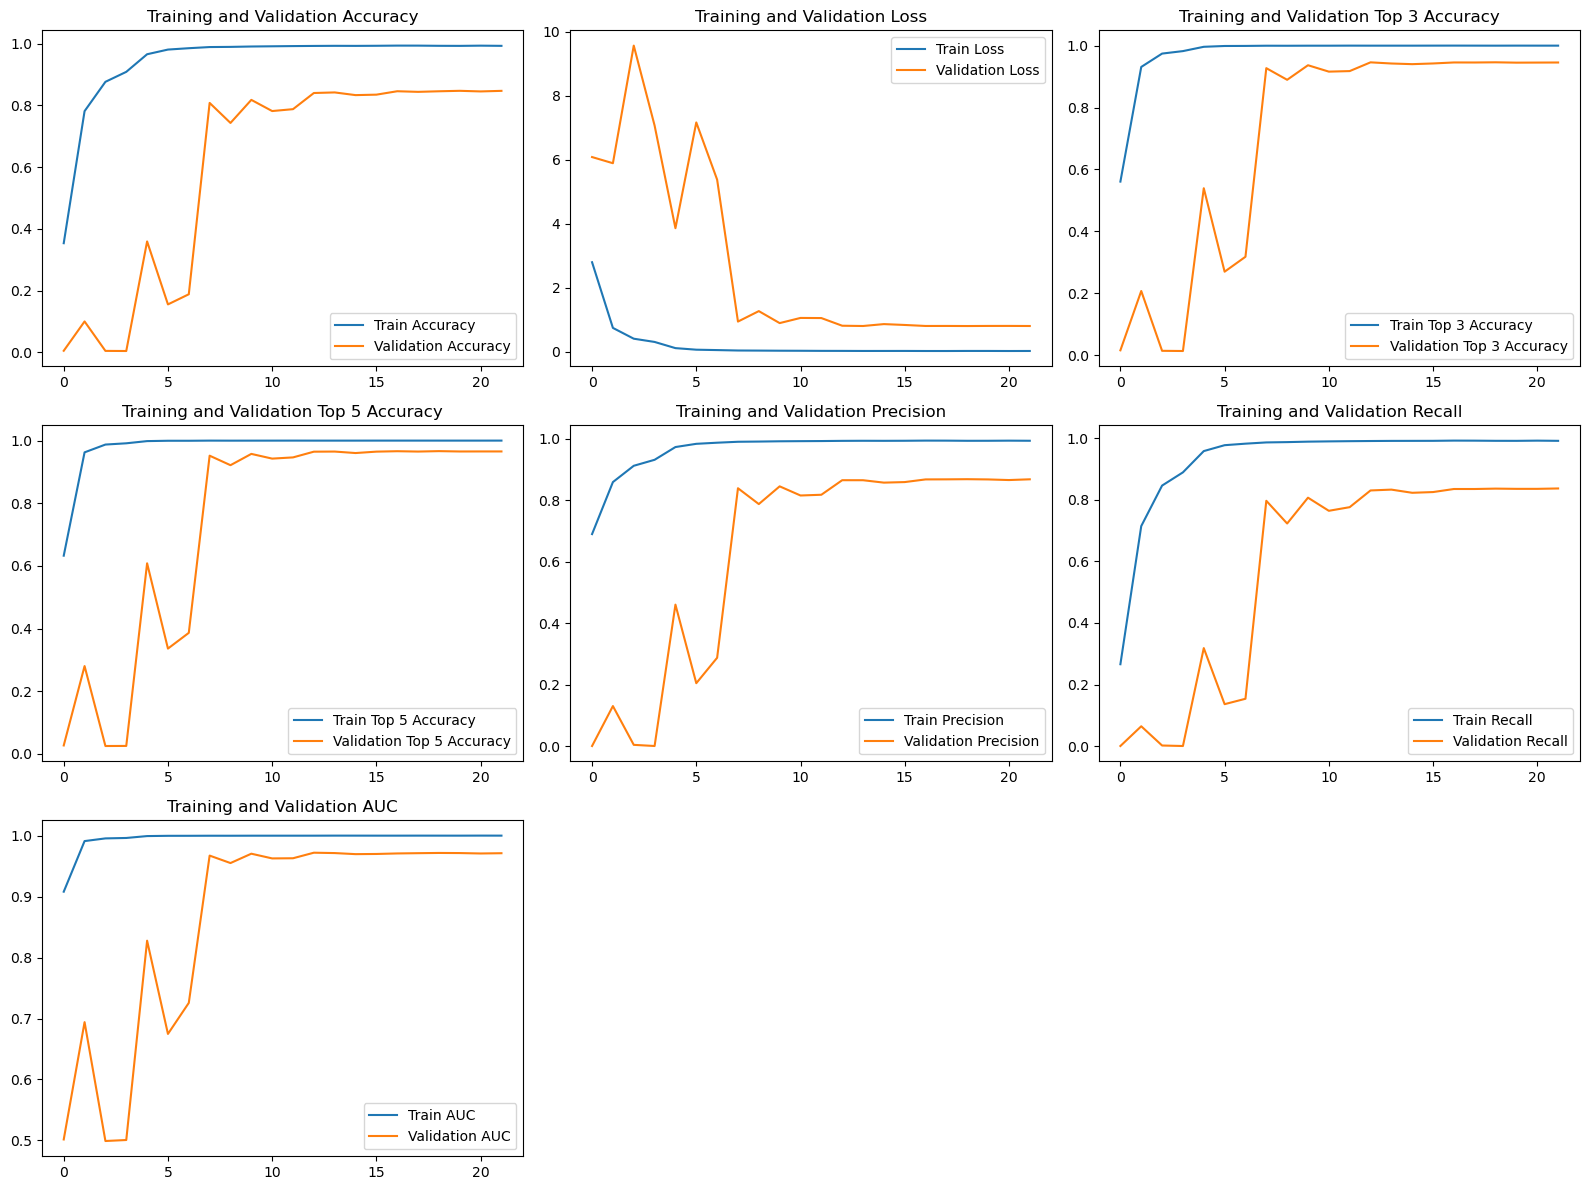

In [104]:
# Train EfficientNet
print("Training model: EfficientNet")
histories_best_hp['EfficientNet'] = run_model_pipeline(create_efficientnet_model, 'EfficientNet', best_params, input_shape, num_classes, train_generator, test_generator, epochs)


In [105]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 11425.992 seconds
Execution time: 190.433 minutes
CPU Execution time: 6813.125 seconds
CPU Execution time: 113.552 minutes


### Train Model 8 - Inceptionv3 (with calculated optimal hyper parameters)

In [106]:
st1 = time.time()
st2 = time.process_time()

Training model: InceptionV3
Number of all layers in the feature-extractor part of the model: 311.
Number of frozen (untrainable) layers in the feature-extractor part of the model: 0.
Summary for InceptionV3:
Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_227 (Conv2D)             (None, 111, 111, 32) 864         input_24[0][0]                   
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 111, 111, 32) 96          conv2d_227[0][0]                 
_________________________________________________________________________________

Epoch 1/22
382/382 [==============================] - 527s 1s/step - loss: 5.2261 - categorical_accuracy: 0.0092 - accuracy: 0.0092 - top_3_acc: 0.1551 - top_5_acc: 0.1706 - precision: 0.8674 - recall: 0.1184 - auc: 0.6355 - val_loss: 9.2329 - val_categorical_accuracy: 0.0127 - val_accuracy: 0.0127 - val_top_3_acc: 0.0298 - val_top_5_acc: 0.0510 - val_precision: 0.0262 - val_recall: 0.0051 - val_auc: 0.5356

Epoch 00001: val_top_3_acc improved from -inf to 0.02985, saving model to InceptionV3_fold_1.h5
Epoch 2/22
382/382 [==============================] - 514s 1s/step - loss: 5.0699 - categorical_accuracy: 0.0151 - accuracy: 0.0151 - top_3_acc: 0.0398 - top_5_acc: 0.0622 - precision: 0.2195 - recall: 1.8418e-04 - auc: 0.6250 - val_loss: 5.3020 - val_categorical_accuracy: 0.0139 - val_accuracy: 0.0139 - val_top_3_acc: 0.0405 - val_top_5_acc: 0.0633 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6126

Epoch 00002: val_top_3_acc improved from 0.02985 to 0.04054, saving 

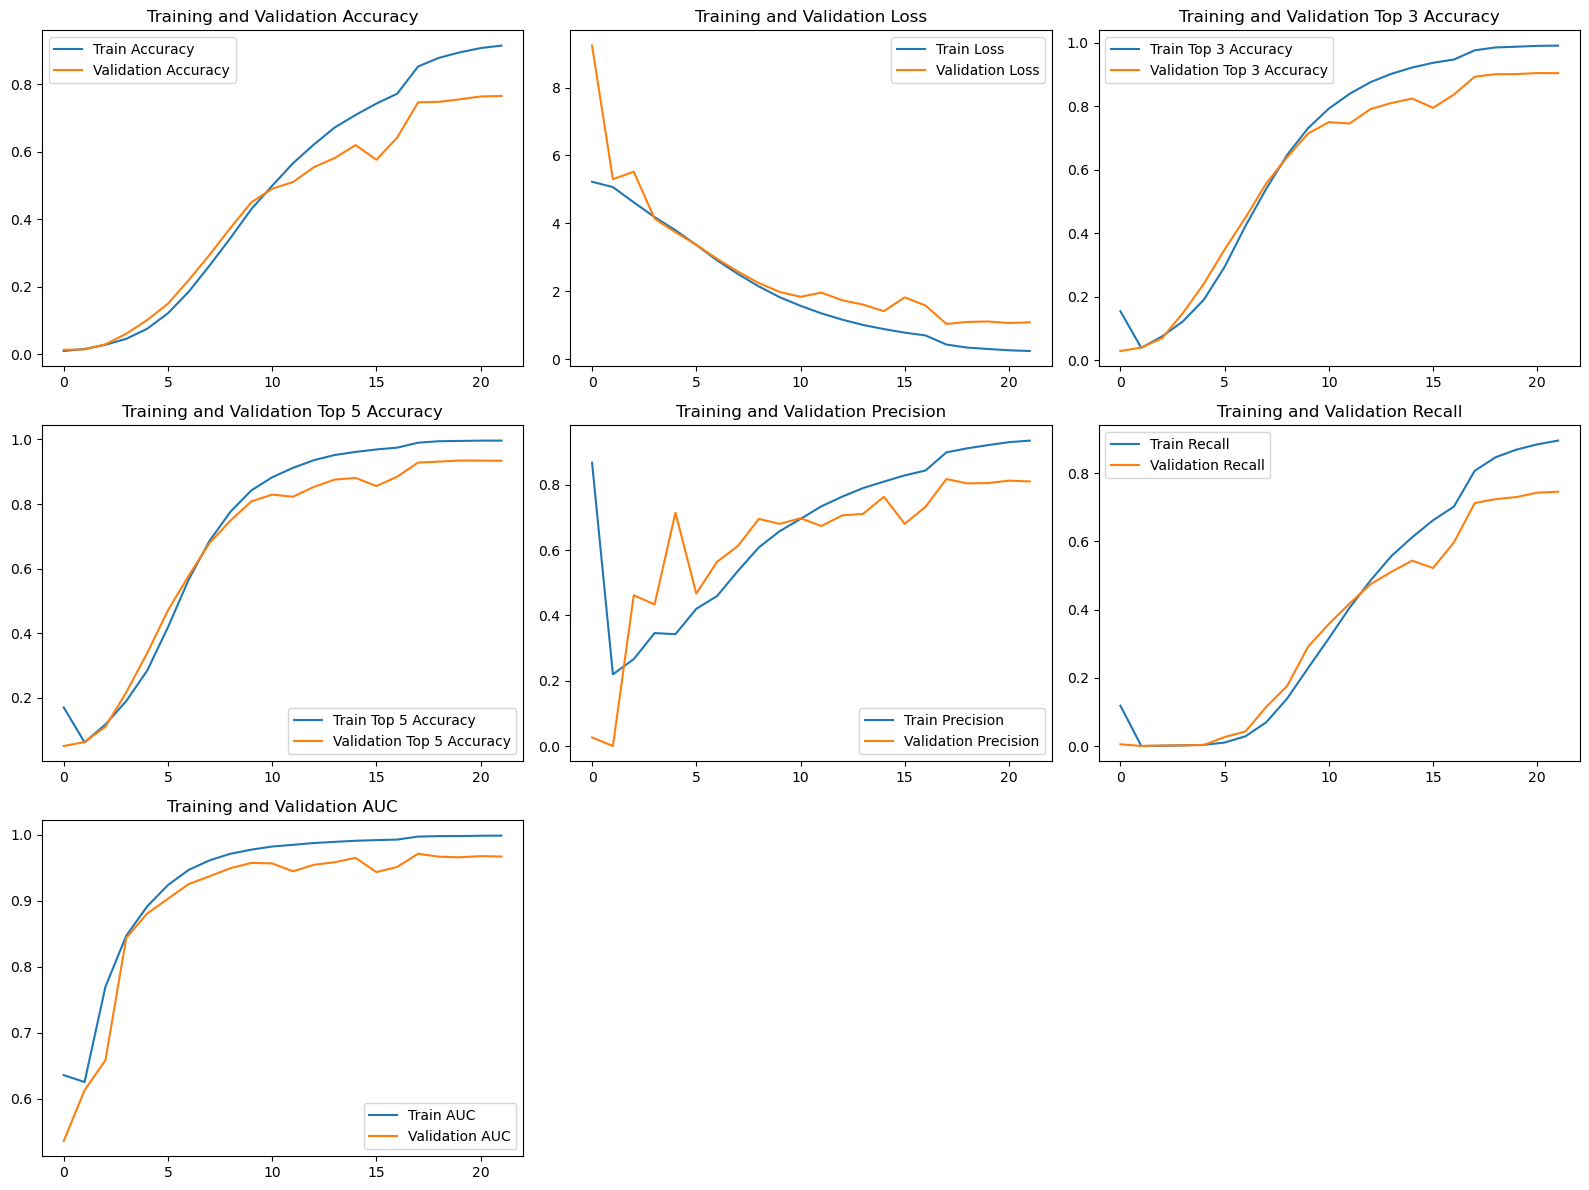

In [107]:
# Train InceptionV3
print("Training model: InceptionV3")
histories_best_hp['Inceptionv3'] = run_model_pipeline(create_inceptionv3_model, 'InceptionV3', best_params, input_shape, num_classes, train_generator, test_generator, epochs)


In [108]:
et1 = time.time()
elt1 = et1 - st1
res1 = elt1 / 60
et2 = time.process_time()
elt2 = et2 - st2
res2 = elt2 / 60

print(f'Execution time: {elt1:.3f} seconds')
print(f'Execution time: {res1:.3f} minutes')
print(f'CPU Execution time: {elt2:.3f} seconds')
print(f'CPU Execution time: {res2:.3f} minutes')

Execution time: 11322.433 seconds
Execution time: 188.707 minutes
CPU Execution time: 6799.953 seconds
CPU Execution time: 113.333 minutes


In [109]:
# add the combined results for comparison

In [110]:
# List of metrics to extract for both train and validation
metrics_best_train = ['categorical_accuracy', 'accuracy', 'top_3_acc', 'top_5_acc', 'precision', 'recall', 'auc']
metrics_best_val = ['val_categorical_accuracy', 'val_accuracy', 'val_top_3_acc', 'val_top_5_acc', 'val_precision', 'val_recall', 'val_auc']

# Extract the final value of each metric for both training and validation for each model
final_results_train_best = {}
final_results_val_best = {}

for model_name, history in histories_best_hp.items():
    final_results_train_best[model_name] = {metric: history[metric][-1] for metric in metrics_def_train}
    final_results_val_best[model_name] = {metric: history[metric][-1] for metric in metrics_def_val}

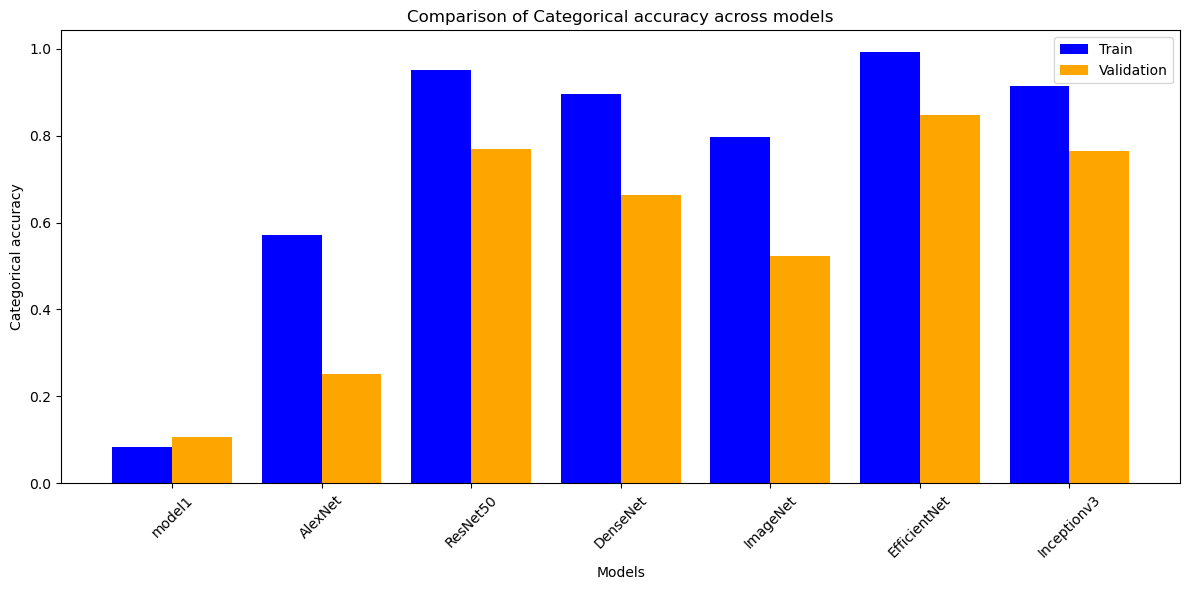

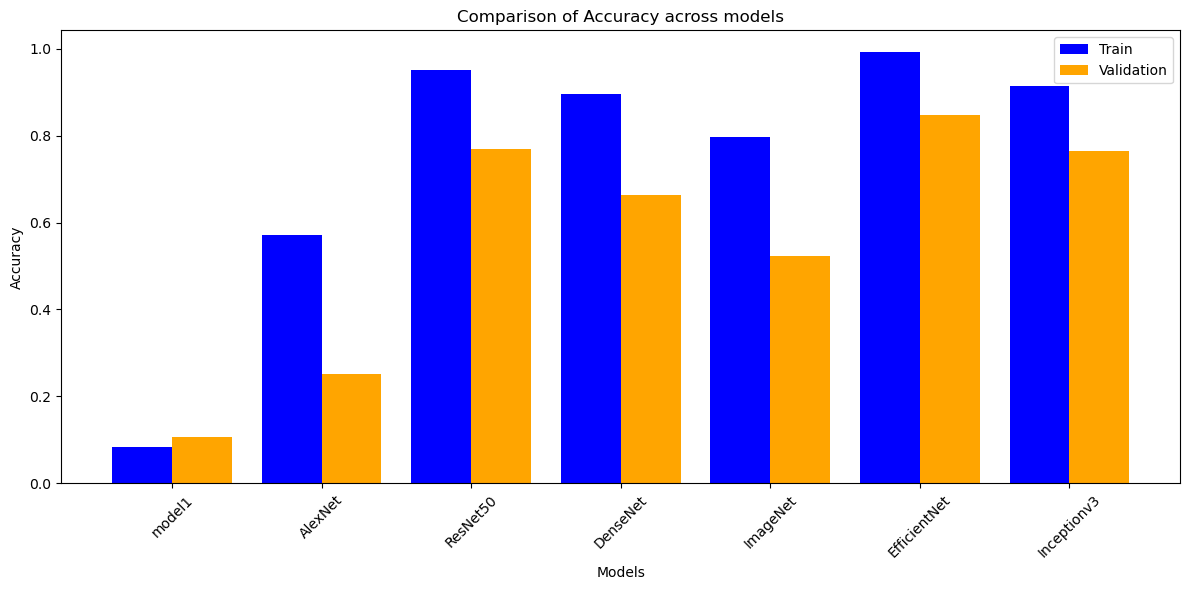

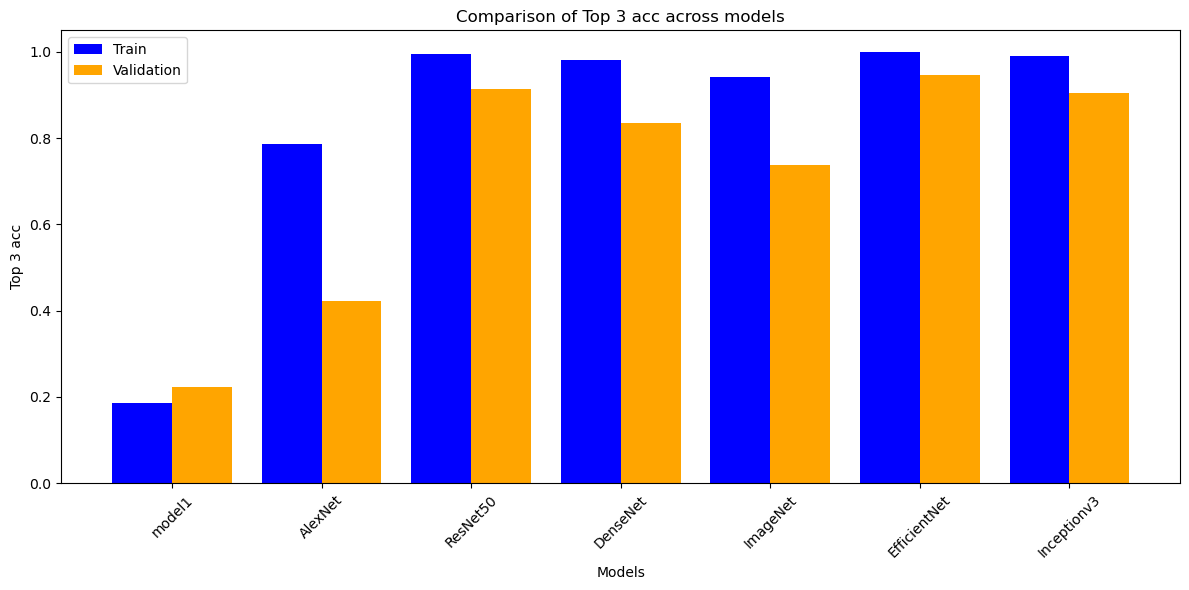

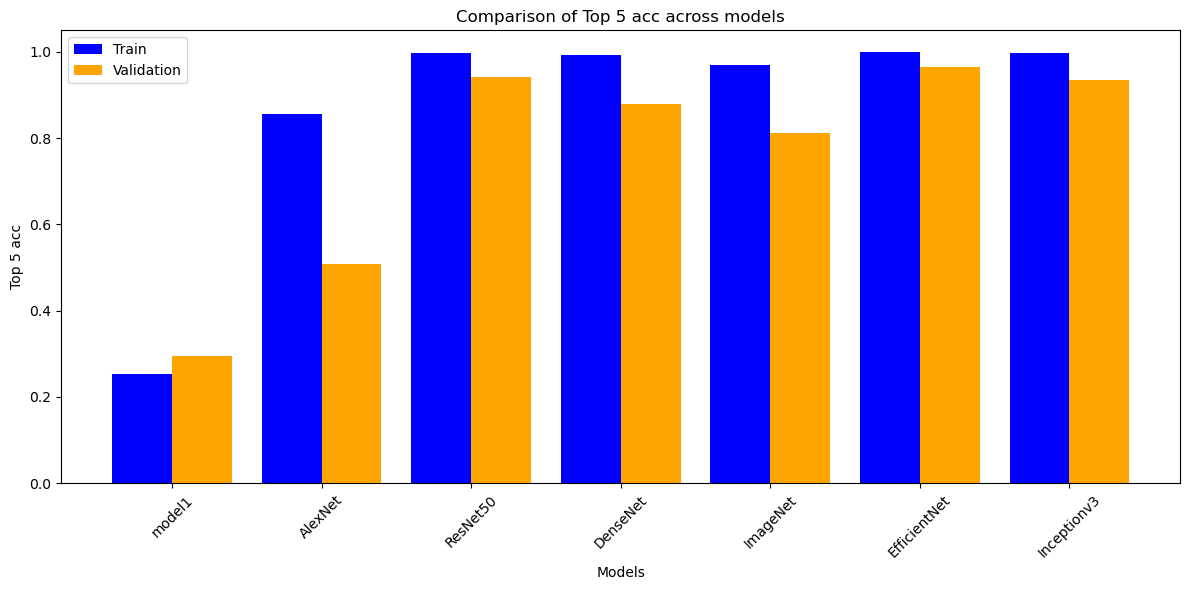

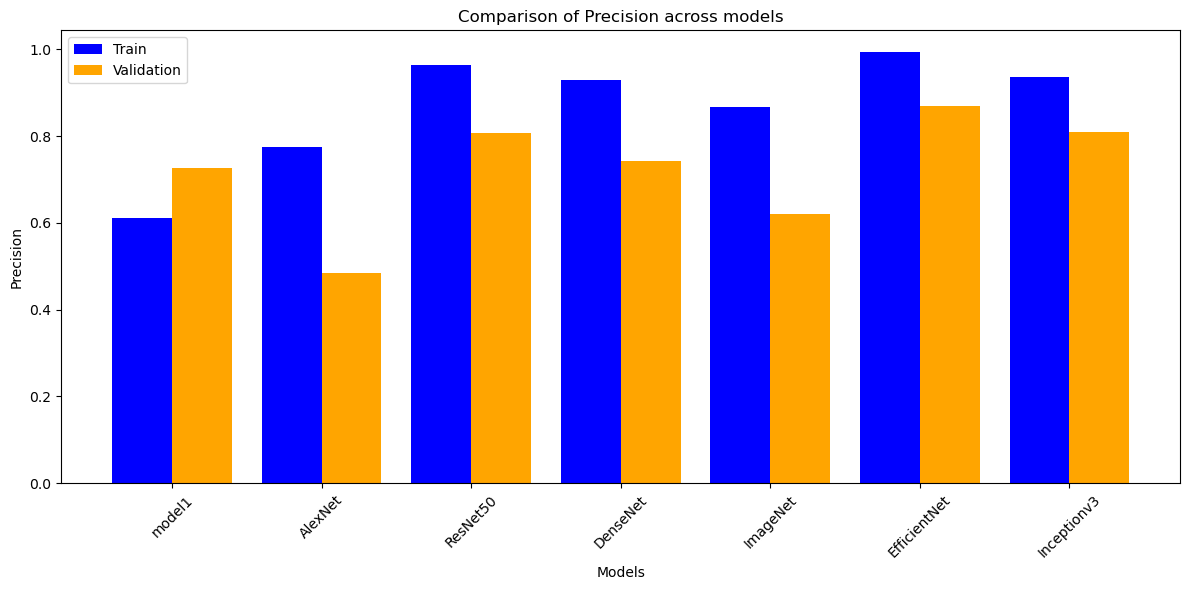

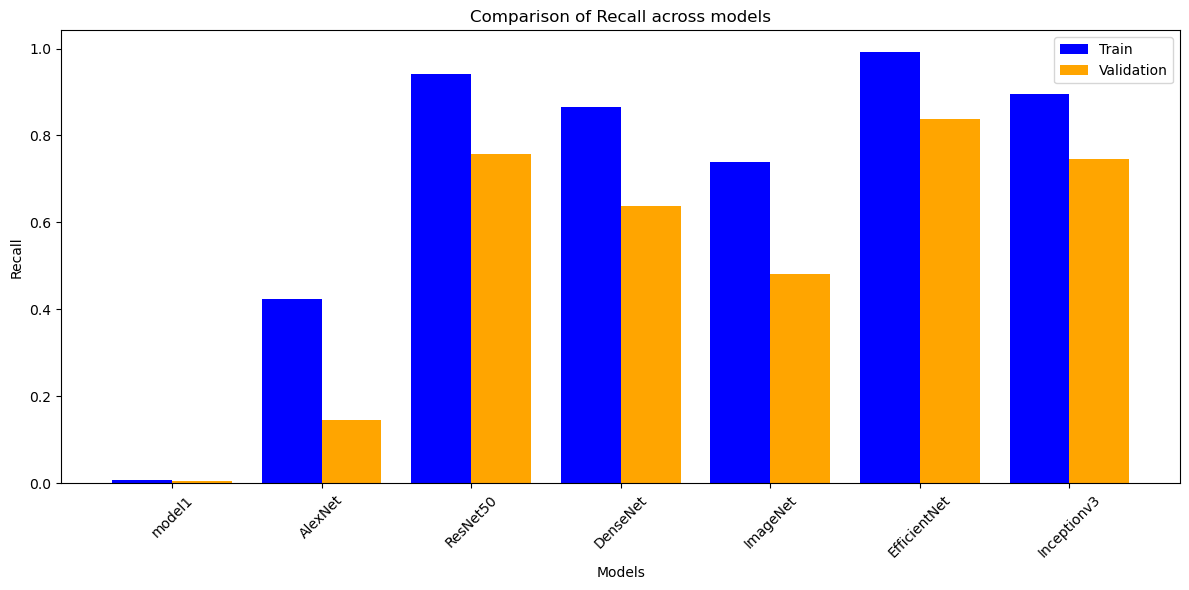

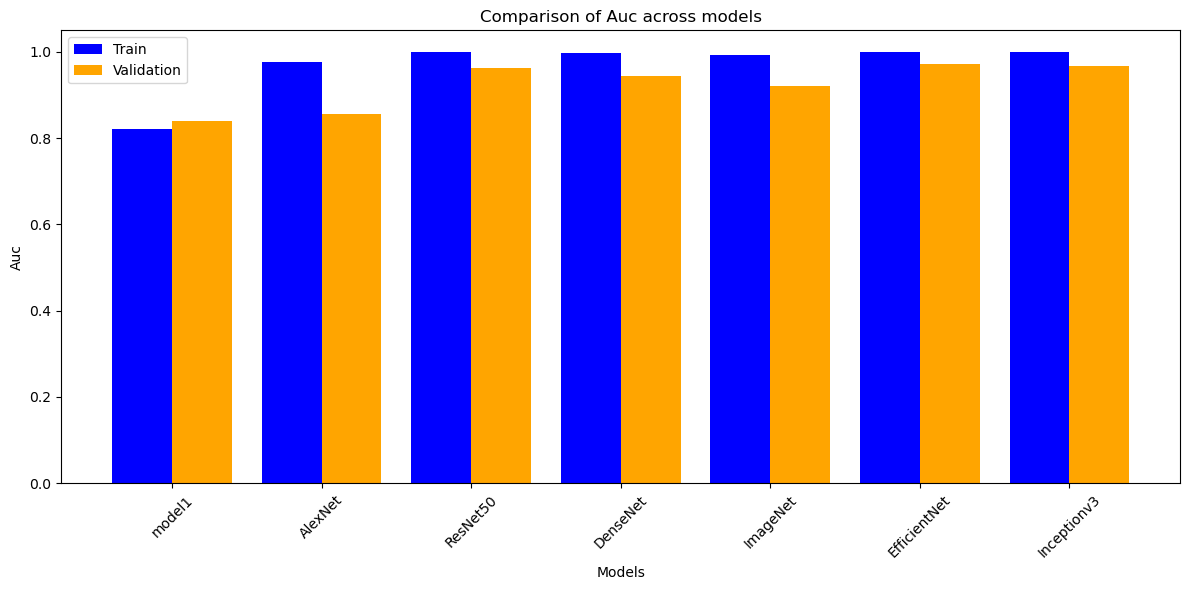

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert the results to pandas DataFrames for easier plotting
df_train = pd.DataFrame(final_results_train_best)
df_val = pd.DataFrame(final_results_val_best)

# Plot each metric with double stacked bars (train in blue, val in orange)
for metric_train, metric_val in zip(metrics_best_train, metrics_best_val):
    plt.figure(figsize=(12, 6))
    
    # Plot train metrics
    width = 0.4  # Bar width
    bar_train = np.arange(len(df_train.columns))
    
    plt.bar(bar_train, df_train.loc[metric_train], width=width, label='Train', color='blue', align='center')
    
    # Plot validation metrics (shifted by width for side-by-side effect)
    bar_val = [i + width for i in bar_train]
    plt.bar(bar_val, df_val.loc[metric_val], width=width, label='Validation', color='orange', align='center')

    # Add labels, title, and legend
    plt.xlabel('Models')
    plt.ylabel(metric_train.replace('_', ' ').capitalize())
    plt.title(f'Comparison of {metric_train.replace("_", " ").capitalize()} across models')
    
    # Show model names as ticks
    plt.xticks(bar_train + width/2, df_train.columns, rotation=45)
    
    # Add legend
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


In [112]:
end = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print('Start time: ',start)
print('End time: ', end)

Start time:  23/10/2024 22:57:37
End time:  26/10/2024 08:00:00


### Time to run the notebook

In [113]:
if isinstance(end, str):
    end1 = datetime.strptime(end, "%d/%m/%Y %H:%M:%S")
if isinstance(start, str):
    start1 = datetime.strptime(start, "%d/%m/%Y %H:%M:%S")

# Calculate the time difference
time_diff = end1 - start1

# Extract hours from the timedelta object
hours = time_diff.total_seconds() / 3600

print(f"Time difference in hours: {hours:.2f}")

Time difference in hours: 57.04


In [ ]:
# Free up GPU memory
tf.keras.backend.clear_session()